In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

2.0.1+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 20.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
import matplotlib.pyplot as plt
import torch
from torch_geometric.datasets import TUDataset
import numpy as np
from termcolor import colored
from torchsummary import summary
from torch.autograd import Variable
from keras import backend as K
from statistics import mean
from operator import add
from sklearn import metrics
from copy import deepcopy
#from captum.attr import Saliency
from scipy.spatial.distance import hamming
from itertools import zip_longest
from time import perf_counter
import csv
import torch.nn as nn
import torch_geometric.nn as gnn
from torch import Tensor
from torch_geometric.typing import OptPairTensor, Adj, OptTensor, Size
from typing import Callable, Union, Tuple
from torch_sparse import SparseTensor
from torch.nn.modules import activation
from time import perf_counter
import random
import pandas
import statistics

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
Explainability_name = 'Grad-CAM'
Task_name = 'Graph Classification'
checkpoint_directory_Classifier = "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/model_classifier.pt"
classifier_lr = 0.001
classifier_dropout = 0.1
classifier_weight_decay = 1e-6
classifier_bias = True
Model_name = "GCN_plus_GAP"
DataSet_name = "MUTAG"
normalize_coeff = 100
File_Name = Model_name + " " + Explainability_name + " " + Task_name + " " + DataSet_name + " "

In [5]:
dataset = TUDataset(root='data/TUDataset', name='MUTAG')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')


data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Extracting data/TUDataset/MUTAG/MUTAG.zip
Processing...



Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2

Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
Number of nodes: 17
Number of edges: 38
Average node degree: 2.24
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Done!


In [6]:
#torch.manual_seed(123456)
#dataset = dataset.shuffle()

#train_dataset = dataset[:150]
#test_dataset = dataset[150:]
df = pandas.read_csv("/content/drive/My Drive/Explainability Methods/Train and Test Indexes on Graph Classification/Experimental Results/train_test_indexes.csv")

read_training_list_indexes__ = df['Train Indexes']
read_test_list_indexes__ = df['Test Indexes']
read_test_list_indexes__ = read_test_list_indexes__.dropna()
read_test_list_indexes = []
read_training_list_indexes = []
for element in read_test_list_indexes__:
    read_test_list_indexes.append(int(element))
for element in read_training_list_indexes__:
    read_training_list_indexes.append(int(element))


print(read_training_list_indexes)
print(read_test_list_indexes)

#print(f'Number of training graphs: {len(train_dataset)}')
#print(f'Number of test graphs: {len(test_dataset)}')

[51, 142, 143, 10, 4, 141, 125, 23, 3, 79, 28, 117, 136, 156, 83, 128, 109, 70, 31, 58, 7, 148, 14, 187, 20, 162, 123, 13, 91, 185, 169, 102, 32, 55, 119, 25, 161, 175, 52, 121, 152, 108, 113, 65, 39, 103, 131, 42, 166, 110, 160, 68, 90, 89, 64, 172, 159, 72, 170, 18, 122, 29, 179, 49, 171, 178, 9, 74, 96, 48, 181, 127, 126, 87, 12, 163, 88, 53, 94, 146, 5, 158, 16, 67, 6, 59, 164, 151, 34, 47, 54, 46, 100, 112, 93, 182, 66, 106, 124, 19, 186, 133, 45, 15, 40, 167, 174, 98, 105, 153, 61, 63, 132, 116, 43, 80, 33, 147, 165, 69, 135, 86, 76, 57, 173, 115, 138, 140, 134, 180, 95, 22, 38, 41, 24, 120, 145, 26, 21, 50, 176, 107, 78, 17, 85, 154, 60, 92, 184, 129]
[0, 1, 2, 8, 11, 27, 30, 35, 36, 37, 44, 56, 62, 71, 73, 75, 77, 81, 82, 84, 97, 99, 101, 104, 111, 114, 118, 130, 137, 139, 144, 149, 150, 155, 157, 168, 177, 183]


In [7]:
train_dataset = []
test_dataset = []
for index in read_training_list_indexes:
    train_dataset.append(dataset[index])
for index in read_test_list_indexes:
    test_dataset.append(dataset[index])


print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 150
Number of test graphs: 38


# **Batching Data by DataLoader**

In [8]:
from torch_geometric.loader import DataLoader

BATCH_SIZE = 64
size_of_hidden_layers = 7

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# **Model Designing**

In [19]:
import sys
py_path = '/content/drive/MyDrive/Explainability Methods/Models/Script/'
sys.path.insert(0,py_path)
import GCN_plus_GAP as Graph_Network
GNN_Model = Graph_Network.GCN_plus_GAP(model_name='GCN_plus_GAP', model_level='graph', input_dim=7, hidden_dim=7, output_dim=2,
                                       num_hid_layers=2, Bias=classifier_bias, act_fun='ReLu', Weight_Initializer=1,
                                       dropout_rate=classifier_dropout)
#import DGCNN as dgcnn_model
#GNN_Model = dgcnn_model.DGCNN_Model(GNN_layers=[32, 32, 32, 7], num_classes=2, mlp_act_fun='ReLu', dgcnn_act_fun='tanh', mlp_dropout_rate=0.5, Weight_Initializer=3, Bias=False, dgcnn_k=20, node_feat_size=7, hid_channels=[16,32], conv1d_kernels=[2,5], ffn_layer_size=128, strides=[2,1])


GCN_plus_GAP Input_Dimension: 7
GCN_plus_GAP Hidden_Dimension: 7
GCN_plus_GAP Output_Dimension: 2
GCN_plus_GAP Number_of_Hidden_Layers: 2
ReLu is Selected.


In [20]:
GNN_Model_optimizer = torch.optim.Adam(GNN_Model.parameters(), lr=classifier_lr, weight_decay=classifier_weight_decay)

In [21]:
criterion = torch.nn.CrossEntropyLoss()
def loss_calculations(preds, gtruth):
    loss_per_epoch = criterion(preds, gtruth)
    return loss_per_epoch

In [22]:
def loading_model(load_index):
    Grad_CAM_model_GCN = GNN_Model(hidden_channels=size_of_hidden_layers)
    Grad_CAM_optimizer = torch.optim.Adam(params = Grad_CAM_model_GCN.parameters(), lr=classifier_lr, weight_decay=classifier_weight_decay)
    checkpoint = torch.load("/content/drive/My Drive/Explainability Methods/"+str(Explainability_name)+" on " + str(Task_name) + "/Model/" + File_Name + str(epoch + load_index + 1)+".pt")
    Grad_CAM_model_GCN.load_state_dict(checkpoint['model_state_dict'])
    Grad_CAM_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']


    return Grad_CAM_model_GCN, Grad_CAM_optimizer, epoch

In [23]:
def visualize_losses(grad_cam_losses, epoch_history):
    grad_cam_losses_list = torch.stack(grad_cam_losses).cpu().detach().numpy()

    fig = plt.figure(figsize=(27,20))

    ax = plt.subplot2grid((3, 1), (0, 0), colspan=1)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title("CAM Model Loss in Epoch: " + str(epoch_history))

    ax.plot(grad_cam_losses_list, color='r')

    plt.savefig('/content/drive/My Drive/Explainability Methods/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/' + File_Name + 'Loss_til_epoch_{:04d}.png'.format(epoch_history))
    plt.show()




# **Traning Configurations**

In [24]:
def train_step():
    Grad_CAM_loss_batch = []
    Grad_CAM_Pred_Labels = []
    Real_Labels = []

    GNN_Model.train()
    GNN_Model.zero_grad()
    for batched_data in train_loader:
        Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = GNN_Model(batched_data)
        pred = soft.argmax(dim=1)
        Grad_CAM_Pred_Labels.extend(pred.detach().tolist())

        Real_Labels.extend(batched_data.y.detach().tolist())
        Grad_CAM_loss = loss_calculations(soft, batched_data.y)
        Grad_CAM_loss_batch.append(Grad_CAM_loss)
        Grad_CAM_loss.backward()
        GNN_Model_optimizer.step()

        GNN_Model_optimizer.step()

    return torch.mean(torch.tensor(Grad_CAM_loss_batch)), metrics.accuracy_score(Real_Labels, Grad_CAM_Pred_Labels)


In [25]:
Visualization_Parameter = 50
Model_Saving_Parameter = 100

In [26]:
Grad_CAM_Model_training_time_per_epoch = []
Grad_CAM_Model_training_Acc_per_epoch = []
def train(EPOCHS, load_index):
    Grad_CAM_training_loss_per_epoch = []

    for epoch in range(EPOCHS):
        start_generation = perf_counter()
        Grad_CAM_model_training_loss, training_acc = train_step()
        Grad_CAM_Model_training_time_per_epoch.append(perf_counter() - start_generation)
        Grad_CAM_Model_training_Acc_per_epoch.append(training_acc)
        print(f'Epoch: {epoch+1:03d}, {Explainability_name} Model Loss: {Grad_CAM_model_training_loss:.4f}')

        Grad_CAM_training_loss_per_epoch.append(Grad_CAM_model_training_loss)
        #break

        if (epoch + load_index + 1) % Visualization_Parameter == 0 and epoch > 0:
            visualize_losses(Grad_CAM_training_loss_per_epoch, epoch + load_index + 1)
        if (epoch + load_index + 1) % Model_Saving_Parameter == 0 and epoch > 0:
            torch.save({'epoch': epoch+load_index+1, 'model_state_dict': GNN_Model.state_dict(), 'optimizer_state_dict': GNN_Model_optimizer.state_dict(), 'loss': Grad_CAM_training_loss_per_epoch,}, "/content/drive/My Drive/Explainability Methods/" + str(Explainability_name) + " on " + str(Task_name) + "/Model/" + File_Name + str(epoch + load_index + 1) + ".pt")


    #return model_loss





Epoch: 001, Grad-CAM Model Loss: 0.6910
Epoch: 002, Grad-CAM Model Loss: 0.6893
Epoch: 003, Grad-CAM Model Loss: 0.6850
Epoch: 004, Grad-CAM Model Loss: 0.6822
Epoch: 005, Grad-CAM Model Loss: 0.6835
Epoch: 006, Grad-CAM Model Loss: 0.6801
Epoch: 007, Grad-CAM Model Loss: 0.6810
Epoch: 008, Grad-CAM Model Loss: 0.6784
Epoch: 009, Grad-CAM Model Loss: 0.6754
Epoch: 010, Grad-CAM Model Loss: 0.6764
Epoch: 011, Grad-CAM Model Loss: 0.6735
Epoch: 012, Grad-CAM Model Loss: 0.6655
Epoch: 013, Grad-CAM Model Loss: 0.6673
Epoch: 014, Grad-CAM Model Loss: 0.6649
Epoch: 015, Grad-CAM Model Loss: 0.6603
Epoch: 016, Grad-CAM Model Loss: 0.6600
Epoch: 017, Grad-CAM Model Loss: 0.6552
Epoch: 018, Grad-CAM Model Loss: 0.6584
Epoch: 019, Grad-CAM Model Loss: 0.6646
Epoch: 020, Grad-CAM Model Loss: 0.6517
Epoch: 021, Grad-CAM Model Loss: 0.6544
Epoch: 022, Grad-CAM Model Loss: 0.6438
Epoch: 023, Grad-CAM Model Loss: 0.6307
Epoch: 024, Grad-CAM Model Loss: 0.6394
Epoch: 025, Grad-CAM Model Loss: 0.6349


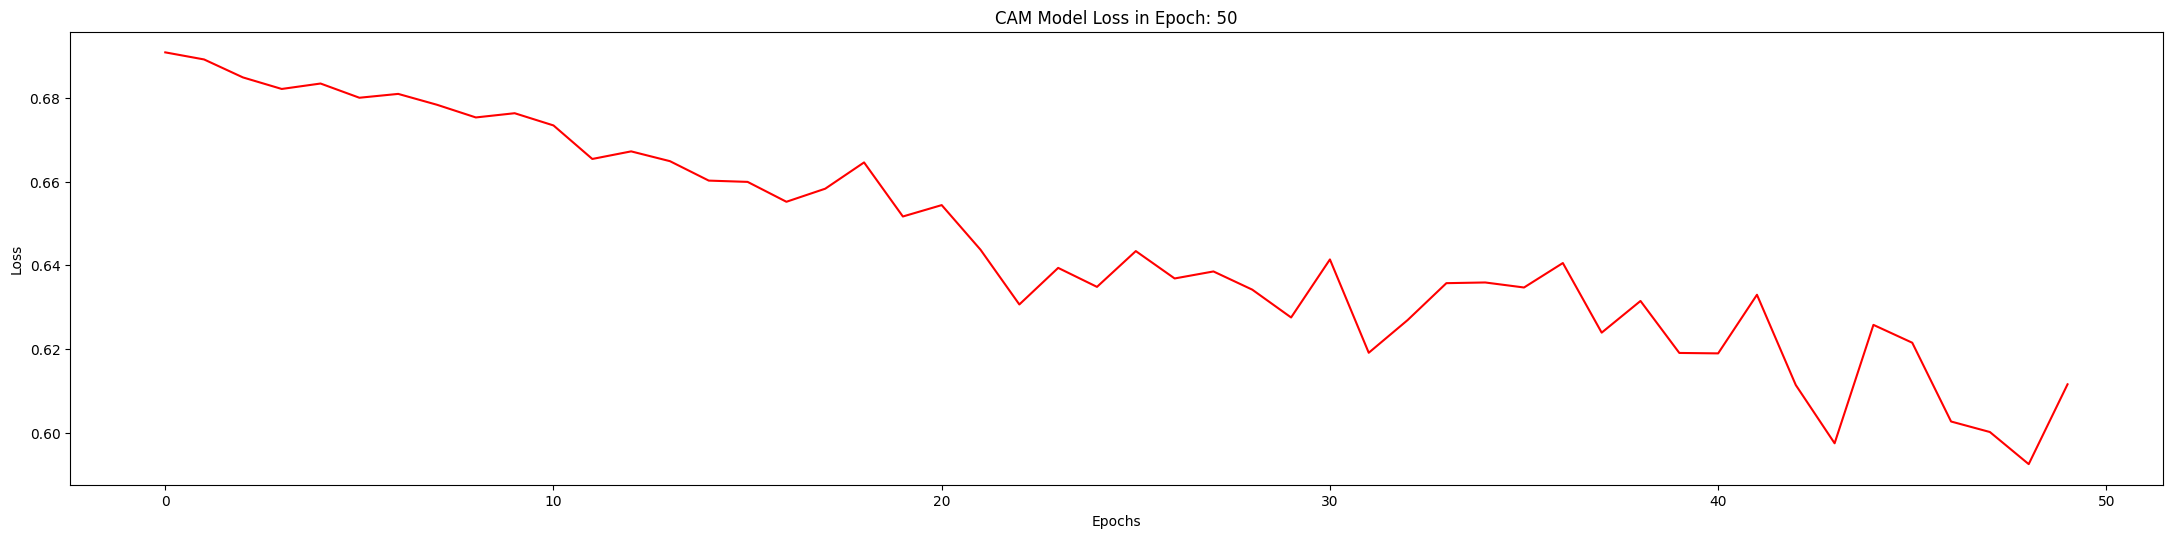

Epoch: 051, Grad-CAM Model Loss: 0.6075
Epoch: 052, Grad-CAM Model Loss: 0.6021
Epoch: 053, Grad-CAM Model Loss: 0.6133
Epoch: 054, Grad-CAM Model Loss: 0.6177
Epoch: 055, Grad-CAM Model Loss: 0.6097
Epoch: 056, Grad-CAM Model Loss: 0.5840
Epoch: 057, Grad-CAM Model Loss: 0.5906
Epoch: 058, Grad-CAM Model Loss: 0.5976
Epoch: 059, Grad-CAM Model Loss: 0.5810
Epoch: 060, Grad-CAM Model Loss: 0.5997
Epoch: 061, Grad-CAM Model Loss: 0.5909
Epoch: 062, Grad-CAM Model Loss: 0.5887
Epoch: 063, Grad-CAM Model Loss: 0.6204
Epoch: 064, Grad-CAM Model Loss: 0.6339
Epoch: 065, Grad-CAM Model Loss: 0.5779
Epoch: 066, Grad-CAM Model Loss: 0.6222
Epoch: 067, Grad-CAM Model Loss: 0.5924
Epoch: 068, Grad-CAM Model Loss: 0.6020
Epoch: 069, Grad-CAM Model Loss: 0.5992
Epoch: 070, Grad-CAM Model Loss: 0.5853
Epoch: 071, Grad-CAM Model Loss: 0.5787
Epoch: 072, Grad-CAM Model Loss: 0.5864
Epoch: 073, Grad-CAM Model Loss: 0.5776
Epoch: 074, Grad-CAM Model Loss: 0.5702
Epoch: 075, Grad-CAM Model Loss: 0.5730


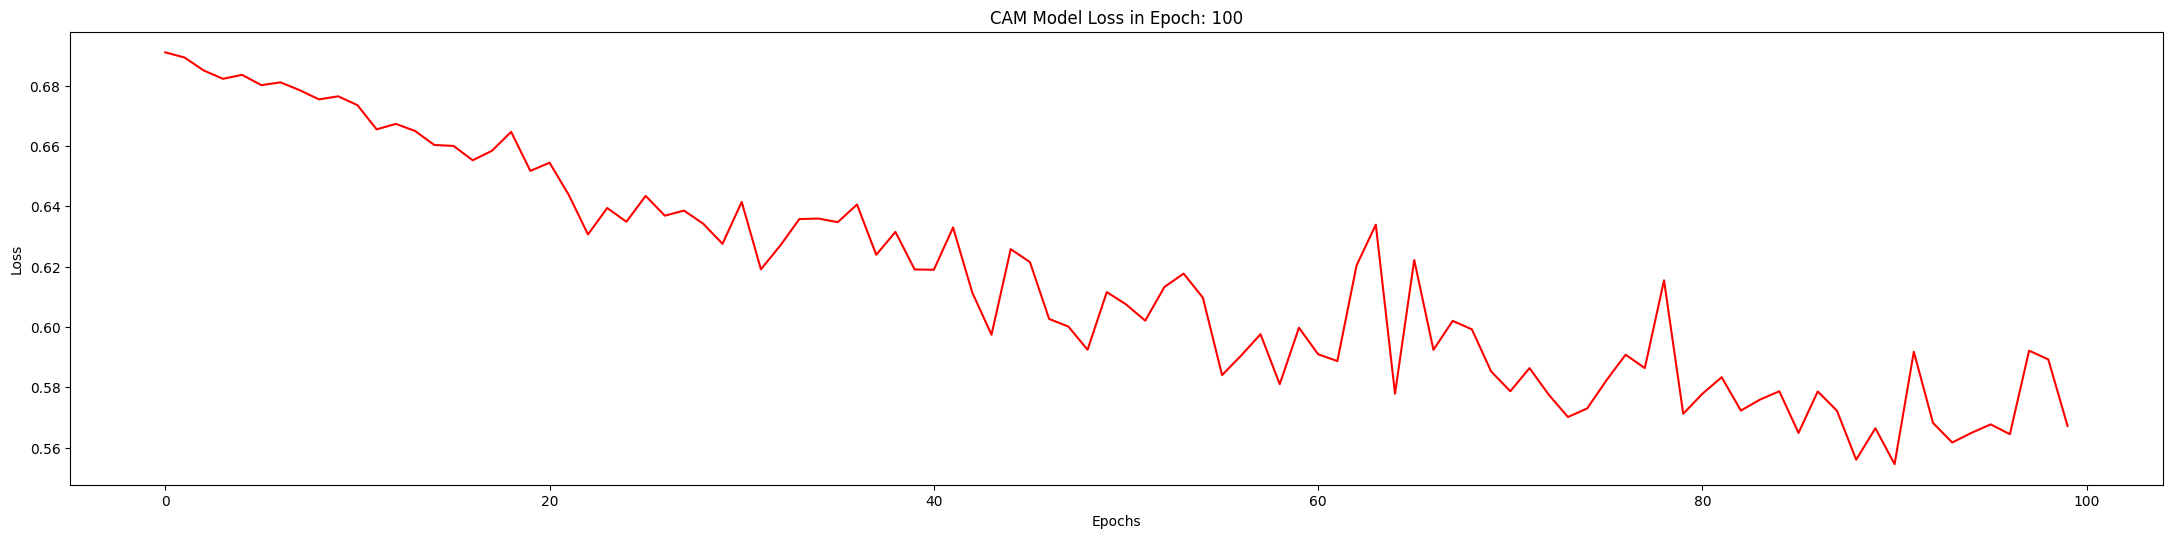

Epoch: 101, Grad-CAM Model Loss: 0.5727
Epoch: 102, Grad-CAM Model Loss: 0.5556
Epoch: 103, Grad-CAM Model Loss: 0.5550
Epoch: 104, Grad-CAM Model Loss: 0.5802
Epoch: 105, Grad-CAM Model Loss: 0.5580
Epoch: 106, Grad-CAM Model Loss: 0.5547
Epoch: 107, Grad-CAM Model Loss: 0.5714
Epoch: 108, Grad-CAM Model Loss: 0.5959
Epoch: 109, Grad-CAM Model Loss: 0.5692
Epoch: 110, Grad-CAM Model Loss: 0.5496
Epoch: 111, Grad-CAM Model Loss: 0.5663
Epoch: 112, Grad-CAM Model Loss: 0.5604
Epoch: 113, Grad-CAM Model Loss: 0.5678
Epoch: 114, Grad-CAM Model Loss: 0.5589
Epoch: 115, Grad-CAM Model Loss: 0.5617
Epoch: 116, Grad-CAM Model Loss: 0.5613
Epoch: 117, Grad-CAM Model Loss: 0.5665
Epoch: 118, Grad-CAM Model Loss: 0.5753
Epoch: 119, Grad-CAM Model Loss: 0.5688
Epoch: 120, Grad-CAM Model Loss: 0.5586
Epoch: 121, Grad-CAM Model Loss: 0.5465
Epoch: 122, Grad-CAM Model Loss: 0.5708
Epoch: 123, Grad-CAM Model Loss: 0.5558
Epoch: 124, Grad-CAM Model Loss: 0.5788
Epoch: 125, Grad-CAM Model Loss: 0.5722


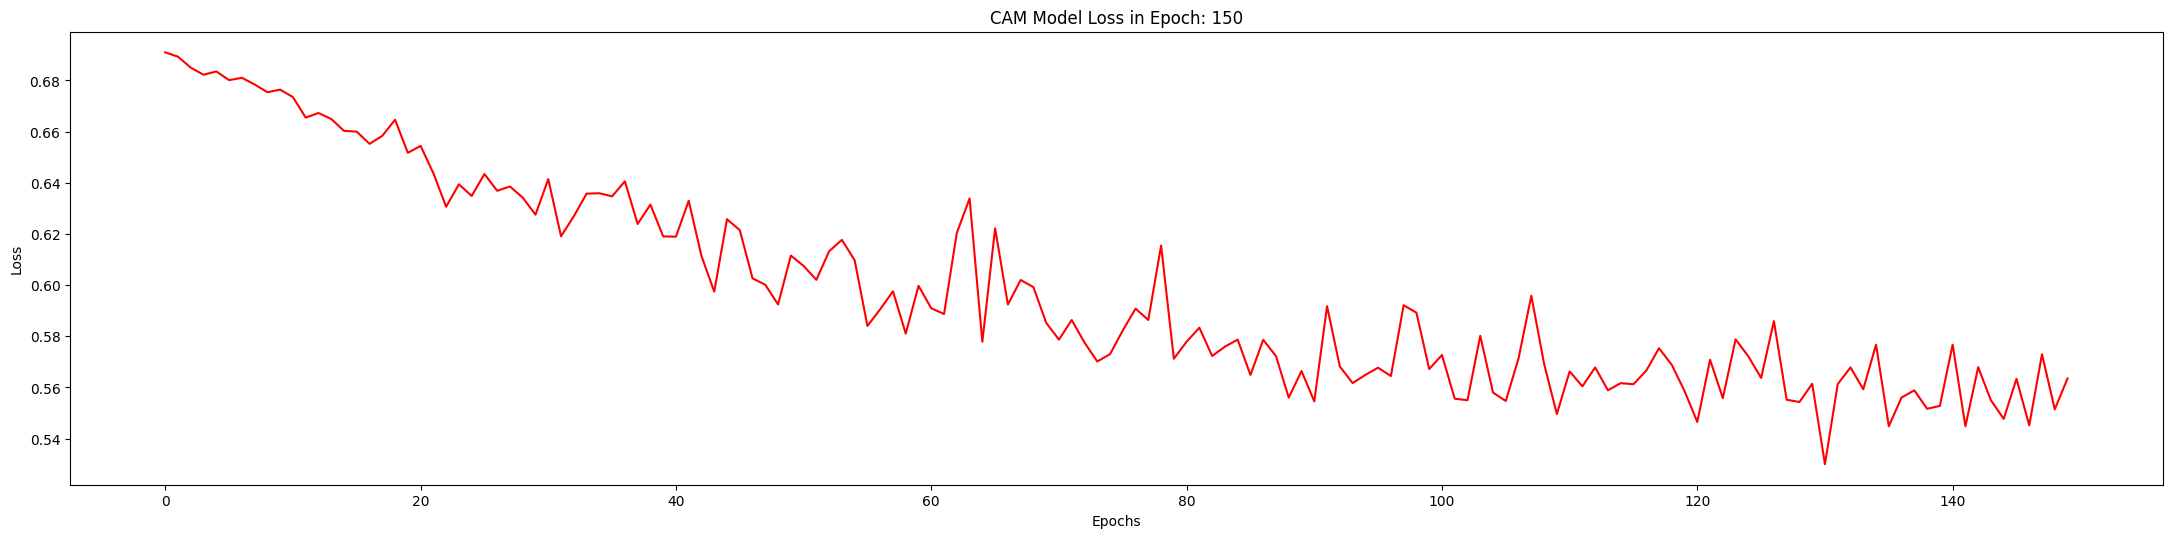

Epoch: 151, Grad-CAM Model Loss: 0.5404
Epoch: 152, Grad-CAM Model Loss: 0.5410
Epoch: 153, Grad-CAM Model Loss: 0.5427
Epoch: 154, Grad-CAM Model Loss: 0.5600
Epoch: 155, Grad-CAM Model Loss: 0.5368
Epoch: 156, Grad-CAM Model Loss: 0.5422
Epoch: 157, Grad-CAM Model Loss: 0.5292
Epoch: 158, Grad-CAM Model Loss: 0.5390
Epoch: 159, Grad-CAM Model Loss: 0.5397
Epoch: 160, Grad-CAM Model Loss: 0.5304
Epoch: 161, Grad-CAM Model Loss: 0.5400
Epoch: 162, Grad-CAM Model Loss: 0.5436
Epoch: 163, Grad-CAM Model Loss: 0.5246
Epoch: 164, Grad-CAM Model Loss: 0.5336
Epoch: 165, Grad-CAM Model Loss: 0.5161
Epoch: 166, Grad-CAM Model Loss: 0.5103
Epoch: 167, Grad-CAM Model Loss: 0.5131
Epoch: 168, Grad-CAM Model Loss: 0.5375
Epoch: 169, Grad-CAM Model Loss: 0.5360
Epoch: 170, Grad-CAM Model Loss: 0.5433
Epoch: 171, Grad-CAM Model Loss: 0.5604
Epoch: 172, Grad-CAM Model Loss: 0.5273
Epoch: 173, Grad-CAM Model Loss: 0.5155
Epoch: 174, Grad-CAM Model Loss: 0.5036
Epoch: 175, Grad-CAM Model Loss: 0.5222


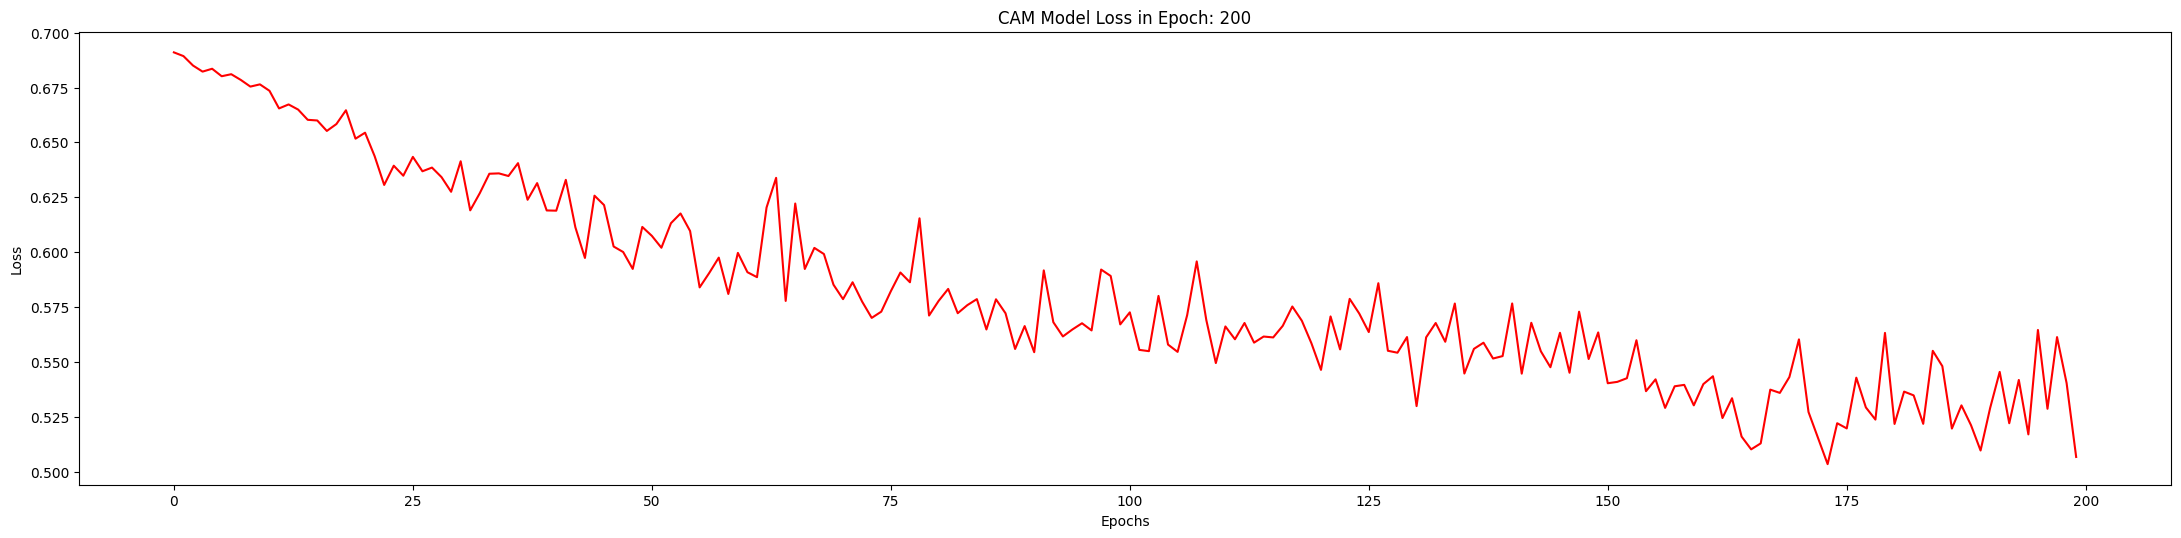

Epoch: 201, Grad-CAM Model Loss: 0.5084
Epoch: 202, Grad-CAM Model Loss: 0.5162
Epoch: 203, Grad-CAM Model Loss: 0.5064
Epoch: 204, Grad-CAM Model Loss: 0.5183
Epoch: 205, Grad-CAM Model Loss: 0.5050
Epoch: 206, Grad-CAM Model Loss: 0.5024
Epoch: 207, Grad-CAM Model Loss: 0.5376
Epoch: 208, Grad-CAM Model Loss: 0.5252
Epoch: 209, Grad-CAM Model Loss: 0.5284
Epoch: 210, Grad-CAM Model Loss: 0.5094
Epoch: 211, Grad-CAM Model Loss: 0.5094
Epoch: 212, Grad-CAM Model Loss: 0.5246
Epoch: 213, Grad-CAM Model Loss: 0.5300
Epoch: 214, Grad-CAM Model Loss: 0.4922
Epoch: 215, Grad-CAM Model Loss: 0.5097
Epoch: 216, Grad-CAM Model Loss: 0.5188
Epoch: 217, Grad-CAM Model Loss: 0.4940
Epoch: 218, Grad-CAM Model Loss: 0.5114
Epoch: 219, Grad-CAM Model Loss: 0.5203
Epoch: 220, Grad-CAM Model Loss: 0.5312
Epoch: 221, Grad-CAM Model Loss: 0.5066
Epoch: 222, Grad-CAM Model Loss: 0.5127
Epoch: 223, Grad-CAM Model Loss: 0.5139
Epoch: 224, Grad-CAM Model Loss: 0.5238
Epoch: 225, Grad-CAM Model Loss: 0.5256


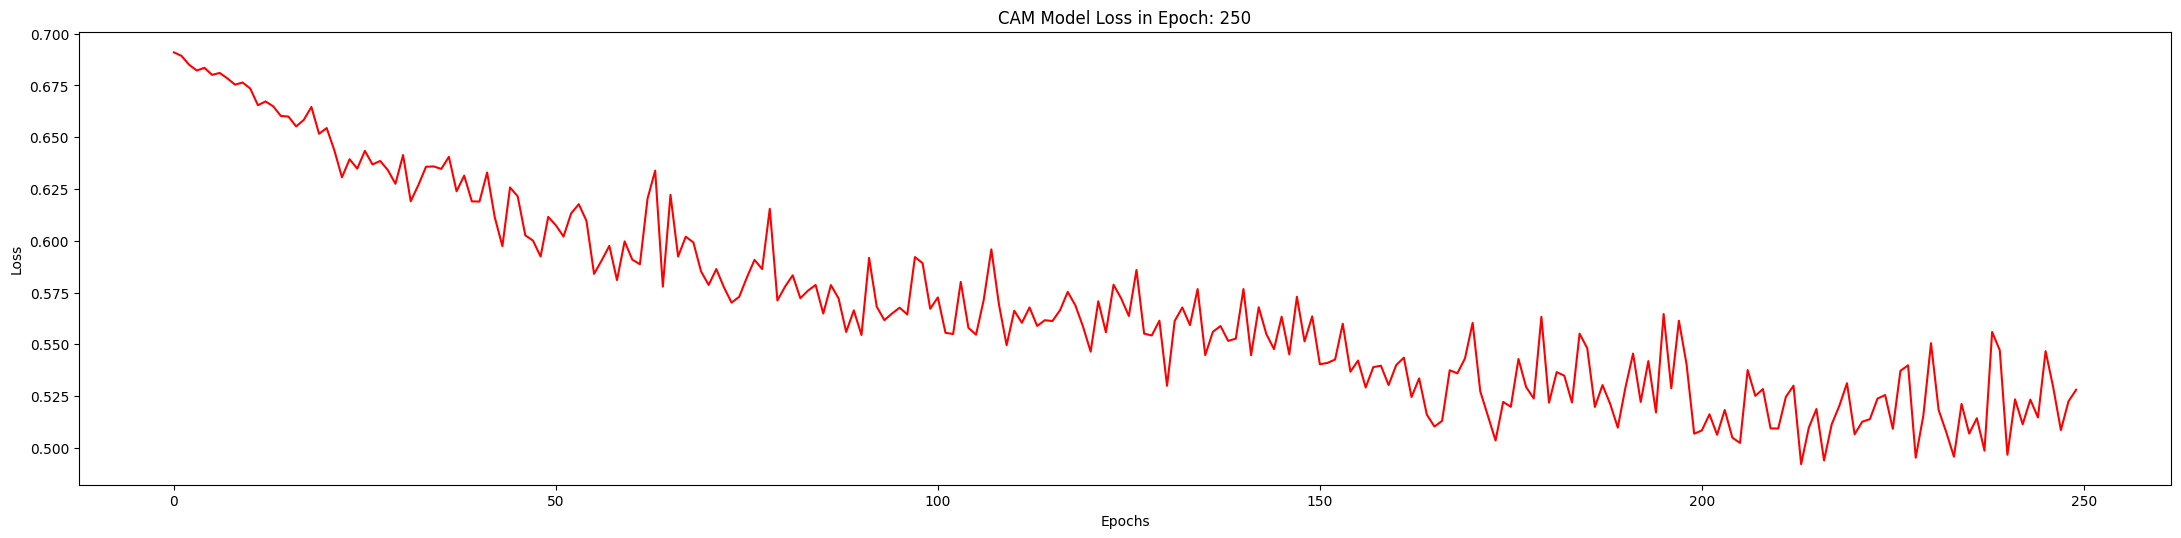

Epoch: 251, Grad-CAM Model Loss: 0.5192
Epoch: 252, Grad-CAM Model Loss: 0.5145
Epoch: 253, Grad-CAM Model Loss: 0.5344
Epoch: 254, Grad-CAM Model Loss: 0.5152
Epoch: 255, Grad-CAM Model Loss: 0.5033
Epoch: 256, Grad-CAM Model Loss: 0.5094
Epoch: 257, Grad-CAM Model Loss: 0.5131
Epoch: 258, Grad-CAM Model Loss: 0.5191
Epoch: 259, Grad-CAM Model Loss: 0.4960
Epoch: 260, Grad-CAM Model Loss: 0.5366
Epoch: 261, Grad-CAM Model Loss: 0.5317
Epoch: 262, Grad-CAM Model Loss: 0.5203
Epoch: 263, Grad-CAM Model Loss: 0.5066
Epoch: 264, Grad-CAM Model Loss: 0.5153
Epoch: 265, Grad-CAM Model Loss: 0.5178
Epoch: 266, Grad-CAM Model Loss: 0.5125
Epoch: 267, Grad-CAM Model Loss: 0.5382
Epoch: 268, Grad-CAM Model Loss: 0.5383
Epoch: 269, Grad-CAM Model Loss: 0.4901
Epoch: 270, Grad-CAM Model Loss: 0.5294
Epoch: 271, Grad-CAM Model Loss: 0.5128
Epoch: 272, Grad-CAM Model Loss: 0.5529
Epoch: 273, Grad-CAM Model Loss: 0.5327
Epoch: 274, Grad-CAM Model Loss: 0.5051
Epoch: 275, Grad-CAM Model Loss: 0.4975


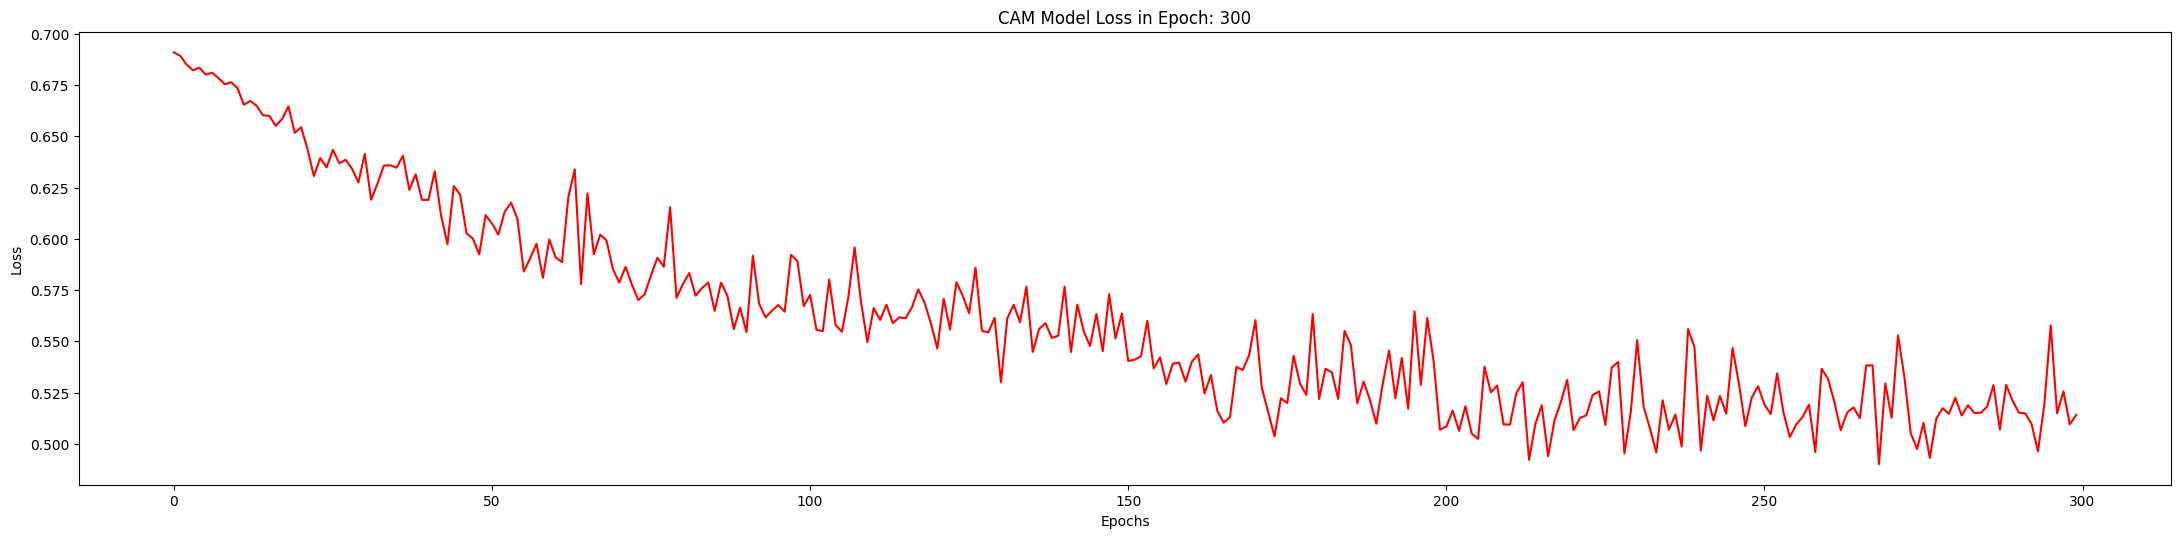

In [27]:
EPOCHS = 300
load_index = 0
if load_index != 0:
    model_GCN, optimizer, load_index = loading_model(load_index)
train(EPOCHS, load_index)

# **Test Configuration for the Model**

In [28]:
def GNN_Model_test(test_loader):
    predictions = []
    GNN_Model.eval()
    correct = 0
    for batched_data in test_loader:
        Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = GNN_Model(batched_data)
        Grad_CAM_test_pred = soft.argmax(dim=1)
        predictions.extend(Grad_CAM_test_pred.detach().tolist())
        #print(Grad_CAM_test_pred)
        correct += int((Grad_CAM_test_pred == batched_data.y).sum())
    return correct / len(test_loader.dataset), predictions

In [29]:
Grad_CAM_test_acc, predictions = GNN_Model_test(test_loader)
print(f'Test Accuracy: {Grad_CAM_test_acc:.4f}')

Test Accuracy: 0.6316


In [30]:
print(predictions)
real_labels = []
for graph in test_dataset:
    real_labels.append(graph.y.detach().tolist()[0])
print(real_labels)

[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1]
[1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1]


In [ ]:
Auc_Roc = metrics.roc_auc_score(real_labels, predictions)
precision, recall, thresholds = metrics.precision_recall_curve(real_labels, predictions)
Auc_Prc = metrics.auc(y=precision, x=recall)
Acc = metrics.accuracy_score(real_labels, predictions, normalize=True)
Acc2 = metrics.accuracy_score(real_labels, predictions, normalize=False)
print(Auc_Roc, Auc_Prc, Acc, Acc2)

0.5803571428571428 0.8156833616298811 0.6578947368421053 25


## **Instance Specific Time**

In [ ]:
def instance_time(test_dataset):
    instance_based_time = []
    GNN_Model.eval()
    correct = 0
    for batched_data in test_dataset:
        start_generation = perf_counter()
        post_conv1, post_conv2, out_readout, Grad_CAM_test_out = GNN_Model(batched_data)
        CAM_test_pred = Grad_CAM_test_out.argmax(dim=1)
        consumed_time = perf_counter() - start_generation
        instance_based_time.append(consumed_time)
    return instance_based_time

In [ ]:
times = instance_time(test_dataset)
print(f'Test Instance based Time: {times}')

Test Instance based Time: [0.0070065879999958725, 0.0010915699999998196, 0.0013423589999774777, 0.0010028599999998278, 0.0009251090000077511, 0.0009682989999930669, 0.0010961700000109431, 0.0009150590000217562, 0.008100387000013143, 0.0012212099999828752, 0.0010124199999950179, 0.003790528000024551, 0.007826857000026166, 0.0011043990000132453, 0.0010477100000230166, 0.0010295890000122654, 0.0009344400000088626, 0.006345468000006349, 0.0015151689999868267, 0.0010895300000015595, 0.0009979490000091573, 0.0009927890000085426, 0.0009195899999951962, 0.0009724699999935638, 0.00824874799999975, 0.0014246589999800108, 0.0009881699999993998, 0.0009554890000060823, 0.0009444099999882383, 0.0009106699999961165, 0.0009101699999973789, 0.008273637000002054, 0.0010513900000148624, 0.0009708700000032877, 0.000916598999992857, 0.0008801689999984319, 0.0008840999999790711, 0.0009132200000010471]


In [ ]:
print(Grad_CAM_model_GCN.conv1)
StateDict = Grad_CAM_model_GCN.state_dict() # STATE DICT is for Weights and Biases
print(StateDict.keys())
whole_weights = StateDict.items()
#print(whole_weights)


Conv1_biases = StateDict.get('conv1.bias')
Conv1_Weights = StateDict.get('conv1.lin.weight')

Conv2_biases = StateDict.get('conv2.bias')
Conv2_Weights = StateDict.get('conv2.lin.weight')

Conv3_biases = StateDict.get('conv3.bias')
Conv3_Weights = StateDict.get('conv3.lin.weight')

Dense_biases = StateDict.get('lin.bias')
Dense_Weights = StateDict.get('lin.weight')

print(f'Length of CONV1_Weights: {len(Conv1_Weights)}')
print(f'Length of CONV1.Bias: {len(Conv1_biases)}')

print(f'Length of CONV2_Weights: {len(Conv2_Weights)}')
print(f'Length of CONV2.Bias: {len(Conv2_biases)}')

print(f'Length of CONV3_Weights: {len(Conv3_Weights)}')
print(f'Length of CONV3.Bias: {len(Conv3_biases)}')

print(f'Length of Dense_Weights: {len(Dense_Weights)}')
print(f'Length of Dense.Bias: {len(Dense_biases)}')


NameError: ignored

In [ ]:
print(Dense_Weights)

# **Gradients of the Last Conv Layer**

In [ ]:
def accumulate_gradients(model_for_you):
    gradients_of_the_Third_Conv_Bias = []
    gradients_of_the_Third_Conv_Weight = []

    for name, param in model_for_you.named_parameters():
        #print("name: ",name)

        if name == "GConvs.0.bias":
            print("name: ",name)
            #print(param.grad)
            gradients_of_the_First_Conv_Bias = param.grad.detach().clone()

        if name == "GConvs.0.lin.weight":
            print("name: ",name)
            gradients_of_the_First_Conv_Weight = param.grad.detach().clone()

        if name == "GConvs.1.bias":
            print("name: ",name)
            gradients_of_the_Second_Conv_Bias = param.grad.detach().clone()

        if name == "GConvs.1.lin.weight":
            print("name: ",name)
            gradients_of_the_Second_Conv_Weight = param.grad.detach().clone()

        #if name == "conv3.bias":
        #    gradients_of_the_Third_Conv_Bias.append(param.grad.detach().clone())

        #if name == "conv3.lin.weight":
        #    gradients_of_the_Third_Conv_Weight.append(param.grad.detach().clone())

        if name == "ffn.bias":
            print("name: ",name)
            gradients_of_the_First_Dense_Bias = param.grad.detach().clone()

        if name == "ffn.weight":
            print("name: ",name)
            gradients_of_the_First_Dense_Weight = param.grad.detach().clone()
        else:
            print("exception: ", name)


    return gradients_of_the_Third_Conv_Weight

In [ ]:
Grads_of_the_Third_Conv_Layer = accumulate_gradients(GNN_Model)

name:  GConvs.0.bias
exception:  GConvs.0.bias
name:  GConvs.0.lin.weight
exception:  GConvs.0.lin.weight
name:  GConvs.1.bias
exception:  GConvs.1.bias
name:  GConvs.1.lin.weight
exception:  GConvs.1.lin.weight
name:  ffn.weight
name:  ffn.bias
exception:  ffn.bias


In [ ]:
print(Grads_of_the_Third_Conv_Layer)

[]


In [31]:
def compute_grad(model, graph, with_respect):
    Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = model(graph)
    #print(prediction)
    if with_respect == 1 :
        loss = loss_calculations(soft, graph.y)
        #print(loss)
        #print("done")
    elif with_respect == 2:
        loss = loss_calculations(soft, torch.tensor([0]))
        #print(loss)
    elif with_respect == 3:
        loss = loss_calculations(soft, torch.tensor([1]))
        #print(loss)
    return torch.autograd.grad(loss, list(model.parameters()),allow_unused=True)

In [32]:
def remove_nones(sample_grads):

    sample_grads2 = []
    for item in sample_grads:
        Each_Graph = []
        for item2 in item:
            if item2 != None:
                Each_Graph.append(torch.tensor(item2.clone().detach().requires_grad_(True),requires_grad=True))
            else:
                Each_Graph.append(torch.tensor(0))
        sample_grads2.append(Each_Graph)

    return sample_grads2

In [33]:
def compute_sample_grads(model, test_dataset, with_respect):

    sample_grads = [compute_grad(model, graph, with_respect) for graph in test_dataset]
    sample_grads = remove_nones(sample_grads)
    sample_grads = zip(*sample_grads)
    sample_grads = [torch.stack(shards) for shards in sample_grads]

    return sample_grads

In [34]:
def compute_grad_cam_gradients(your_model, dataset):
    per_sample_grads_wrt_graph_label = compute_sample_grads(your_model, dataset, 1)
    per_sample_grads_wrt_class_zero = compute_sample_grads(your_model, dataset, 2)
    per_sample_grads_wrt_class_one = compute_sample_grads(your_model, dataset, 3)

    #print(np.shape(per_sample_grads_wrt_graph_label[0]))
    #print(np.shape(per_sample_grads_wrt_graph_label[1]))
    #print(np.shape(per_sample_grads_wrt_graph_label[2]))
    #print(np.shape(per_sample_grads_wrt_graph_label[3]))
    #print(np.shape(per_sample_grads_wrt_graph_label[4]))
    #print(np.shape(per_sample_grads_wrt_graph_label[5]))
    #print(np.shape(per_sample_grads_wrt_graph_label[6]))
    #print(np.shape(per_sample_grads_wrt_graph_label[7]))

    grads_wrt_graph_label = per_sample_grads_wrt_graph_label[1].detach().tolist()

    grads_wrt_class_zero = per_sample_grads_wrt_class_zero[1].detach().tolist()

    grads_wrt_class_one = per_sample_grads_wrt_class_one[1].detach().tolist()

    grads_wrt_graph_label = column_wise_addups(grads_wrt_graph_label)
    grads_wrt_class_zero = column_wise_addups(grads_wrt_class_zero)
    grads_wrt_class_one = column_wise_addups(grads_wrt_class_one)

    return grads_wrt_graph_label, grads_wrt_class_zero, grads_wrt_class_one

In [35]:
def column_wise_addups(gradients):
    return np.sum(np.abs(gradients), axis=1).tolist()

In [ ]:
grads_wrt_graph_label, grads_wrt_class_zero, grads_wrt_class_one = compute_grad_cam_gradients(GNN_Model, test_dataset)
print(np.shape(grads_wrt_graph_label), np.shape(grads_wrt_class_zero), np.shape(grads_wrt_class_one))

<ipython-input-57-f6d1329d677b>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Each_Graph.append(torch.tensor(item2.clone().detach().requires_grad_(True),requires_grad=True))


(38, 7) (38, 7) (38, 7)


In [ ]:
print("grads_wrt_class_zero: ", grads_wrt_class_zero)
print("grads_wrt_class_one: ", grads_wrt_class_one)

grads_wrt_class_zero:  [[0.11070090113207698, 0.0035214129493397195, 0.004024140231194906, 0.0, 0.0, 0.0, 0.0], [3.476156860589981, 0.5173687860369682, 0.2196879591792822, 0.0, 0.0, 0.0, 0.0], [3.607485771179199, 0.5467673316597939, 0.2271683095023036, 0.0, 0.0, 0.0, 0.0], [1.639691337943077, 0.45334992185235023, 0.15052025485783815, 0.0, 0.0, 0.0, 0.0], [0.3276900826022029, 0.020956955471774563, 0.011070174514316022, 0.0, 0.0, 0.0, 0.0], [1.297642707824707, 0.04956039763055742, 0.05749927647411823, 0.05406688712537289, 0.0, 0.0, 0.0], [0.4335406981408596, 0.02499478610116057, 0.029828227474354208, 0.0, 0.0, 0.0, 0.0], [0.19086000323295593, 0.007819150487193838, 0.00912618453730829, 0.0, 0.0, 0.0, 0.0], [0.11014603497460485, 0.0035030264680244727, 0.004002969362773001, 0.0, 0.0, 0.0, 0.0], [0.15611433004960418, 0.005886838313017506, 0.006744756217813119, 0.0, 0.0, 0.0, 0.0], [3.8817992359399796, 0.6791820134967566, 0.7879740670323372, 0.0, 0.0, 0.0, 0.0], [3.346783831715584, 0.42383897

# **Feature MAPs**

In [36]:
def Grad_CAM_FeatureMAP_production(test_loader):
    index_of_winner_labels = []
    FeatureMaps_of_the_Last_Conv = []
    output_of_the_GAP = []
    Final_predictions = []

    GNN_Model.eval()
    for batched_data in test_loader:
        Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = GNN_Model(batched_data)
        #index_of_winner_label = CAM_output.argmax(dim=1)
        #logits = F.log_softmax(Grad_CAM_Test_out, dim=1)
        #prob = F.softmax(logits, dim=1)
        index_of_winner_label = soft.argmax(dim=1)

        index_of_winner_labels.append(index_of_winner_label.detach().tolist())
        Final_predictions.append(soft.detach().tolist())

        FeatureMaps_of_the_Last_Conv.append(Output_of_Hidden_Layers[1].detach().tolist())
    return FeatureMaps_of_the_Last_Conv, Final_predictions, index_of_winner_labels

In [ ]:
FeatureMaps_of_the_Last_Conv, Final_predictions, index_of_winner_labels = Grad_CAM_FeatureMAP_production(test_dataset)

# **Attribution of Gradients and Maps**

In [37]:
from numpy import exp
def softmax(vector):
    e = exp(vector)
    return e / e.sum()

In [38]:
def normalize_for_large_gap(sal_maps, contrast_coeff):
    final = []
    for graph in sal_maps:
        temp = []
        for node in graph:
            temp2 = []
            for score in node:
                if score != max(node):
                    temp2.append(score*contrast_coeff - int(score*contrast_coeff))
                else:
                    temp2.append(score)
            temp.append(temp2)
        final.append(temp)
    return final

In [40]:
def Grad_CAM_Attribution_Scores(GNN_Model, test_dataset):
    FeatureMaps_of_the_Last_Conv, Final_predictions, index_of_winner_labels = Grad_CAM_FeatureMAP_production(test_dataset)
    grads_wrt_graph_label, grads_wrt_class_zero, grads_wrt_class_one = compute_grad_cam_gradients(GNN_Model, test_dataset)

    Grads_and_Maps_Multiplication_on_Nodes_of_each_graph_zero = []
    Grads_and_Maps_Multiplication_on_Nodes_of_each_graph_one = []
    Grads_and_Maps_Multiplication_on_Nodes_of_each_graph_glabel = []
    Normalized_Attributions = []
    #print("fet: ",np.shape(feat_maps))
    #print(np.shape(grads))

    #Graphs_new_gradients = []
    #for graph_grads in grads_wrt:
    #    new_gradients = []
    #    for dim in graph_grads:
    #        new_gradients.append(((dim-min(graph_grads))*normalize_coeff)/(max(graph_grads)-min(graph_grads)))
    #    Graphs_new_gradients.append(new_gradients)


    for i in range(len(FeatureMaps_of_the_Last_Conv)):
        Each_Graph = []
        for j in range(len(FeatureMaps_of_the_Last_Conv[i])):
            Each_Graph.append(np.sum(np.multiply(grads_wrt_class_zero[i], FeatureMaps_of_the_Last_Conv[i][j])))
        Grads_and_Maps_Multiplication_on_Nodes_of_each_graph_zero.append(Each_Graph)


    for i in range(len(FeatureMaps_of_the_Last_Conv)):
        Each_Graph = []
        for j in range(len(FeatureMaps_of_the_Last_Conv[i])):
            Each_Graph.append(np.sum(np.multiply(grads_wrt_class_one[i], FeatureMaps_of_the_Last_Conv[i][j])))
        Grads_and_Maps_Multiplication_on_Nodes_of_each_graph_one.append(Each_Graph)


    for i in range(len(FeatureMaps_of_the_Last_Conv)):
        Each_Graph = []
        for j in range(len(FeatureMaps_of_the_Last_Conv[i])):
            Each_Graph.append(np.sum(np.multiply(grads_wrt_graph_label[i], FeatureMaps_of_the_Last_Conv[i][j])))
        Grads_and_Maps_Multiplication_on_Nodes_of_each_graph_glabel.append(Each_Graph)
    #print("Grads_and_Maps_Multiplication_on_Nodes_of_each_graph[0]: ", Grads_and_Maps_Multiplication_on_Nodes_of_each_graph[0])
    #Grads_and_Maps_Multiplication_on_Nodes_of_each_graph = normalize_for_large_gap(Grads_and_Maps_Multiplication_on_Nodes_of_each_graph, 100)



    #Normalized_Attributions = []
    #for i in range(len(Grads_and_Maps_Multiplication_on_Nodes_of_each_graph)):
    #    Each_Graph = []
    #    for j in range(len(Grads_and_Maps_Multiplication_on_Nodes_of_each_graph[i])):
    #        each_node = []
    #        for k in range(len(Grads_and_Maps_Multiplication_on_Nodes_of_each_graph[i][j])):
    #            each_node.append((Grads_and_Maps_Multiplication_on_Nodes_of_each_graph[i][j][k]-min(Grads_and_Maps_Multiplication_on_Nodes_of_each_graph[i][j]))/(max(Grads_and_Maps_Multiplication_on_Nodes_of_each_graph[i][j])-min(Grads_and_Maps_Multiplication_on_Nodes_of_each_graph[i][j])))
    #        Each_Graph.append(each_node)
    #    #norm = softmax(Each_Graph).tolist()
    #    Normalized_Attributions.append(Each_Graph)
    return Grads_and_Maps_Multiplication_on_Nodes_of_each_graph_zero, Grads_and_Maps_Multiplication_on_Nodes_of_each_graph_one, Grads_and_Maps_Multiplication_on_Nodes_of_each_graph_glabel

In [ ]:
print(np.shape(grads_wrt_graph_label))
print(np.shape(FeatureMaps_of_the_Last_Conv[0]))

(38, 7)
(17, 7)


In [41]:
start_time = perf_counter()
atts_class0, atts_class1, atts_class_glabel = Grad_CAM_Attribution_Scores(GNN_Model, test_dataset)
consumed_time = perf_counter() - start_time
print(consumed_time/(3*len(test_dataset)))
print(np.shape(atts_class0))
print(atts_class0)


0.0030998799385963793
(38,)
[[0.670076064018715, 0.670076064018715, 0.6511141934024458, 0.7221504688114928, 0.7294411515798082, 0.6590216647188014, 0.6484784114827059, 0.6484784114827059, 0.7203104098530864, 0.7221504065275792, 0.640570941716783, 0.47570807075704147, 0.30502737977560435, 0.46465373106836105, 0.0012513365376145766, 0.0, 0.0], [13.935489332826046, 13.921505862430594, 11.864149556581989, 13.921505862430594, 8.713237713724352, 3.2711515889718723, 0.708683519391698, 3.93509401483729, 2.9490875936100602, 10.221891587878126, 0.04133679667713552, 0.0, 0.0], [14.115918783481938, 9.968478763189058, 7.245983798729404, 8.761820076373022, 13.934745694867654, 8.827561082988865, 3.3165366932679383, 0.7363858661367726, 6.569167030084825, 10.355231191756946, 0.04189724942559314, 0.0, 0.0], [2.024019363596384, 1.9199502345232848, 0.8133048338650604, 0.18253086477151714, 0.1952878391053492, 0.18253086477151714, 0.7763760860217052, 1.2011331228026867, 1.3257555173939592, 0.010320393143132

<ipython-input-32-f6d1329d677b>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Each_Graph.append(torch.tensor(item2.clone().detach().requires_grad_(True),requires_grad=True))
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [42]:
import sys
from importlib import reload
py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
sys.path.insert(0,py_path)
import evaluation_of_xmethods_fidelity_plus as eval_xai_fid_plus
eval_xai_fid_plus = reload(eval_xai_fid_plus)

In [44]:
fid_xmethod_example_2 = eval_xai_fid_plus.evalaution_of_xmethods_fidelity_plus(model_name="GCN_plus_GAP", a_trained_model=GNN_Model,
                                                                               test_data=test_dataset)
fid_score2 = fid_xmethod_example_2.my_fidelity(saliency_class0=atts_class0, saliency_class1=atts_class1, importance_threshold=0.01,
                                               style="Node")
print(fid_score2)

0.2827380952380953


In [65]:
import sys
py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
sys.path.insert(0,py_path)
import evaluation_of_xmethods_contrastivity as eval_xai_contrastivity
eval_xai_contrastivity = reload(eval_xai_contrastivity)

In [68]:
contrastivity_xmethod_example = eval_xai_contrastivity.evalaution_of_xmethods_contrastivity(model_name="GCN_plus_GAP",
                                                                                            a_trained_model=GNN_Model,
                                                                                            test_data=test_dataset)
contrastivity_score = contrastivity_xmethod_example.my_contrastivity(test_dataset, atts_class0,
                                                                     atts_class1, importance_threshold=0.5,
                                                                     contrast_coeff=1e+11)
print("Contrastivity_Score: ", contrastivity_score)

Contrastivity_Score:  0.43207126129863127


In [69]:
import sys
py_path = '/content/drive/MyDrive/Explainability Methods/Evaluation of Explainability Methods/Script/'
sys.path.insert(0,py_path)
import evaluation_of_xmethods_sparsity as eval_xai_sparsity
eval_xai_sparsity = reload(eval_xai_sparsity)

In [71]:
sparsity_xmethod_example = eval_xai_sparsity.evalaution_of_xmethods_sparsity(model_name="GCN_plus_GAP", a_trained_model=GNN_Model,
                                                                     test_data=test_dataset)
sparsity_score = sparsity_xmethod_example.my_sparsity(test_dataset, atts_class0, atts_class1, importance_threshold=0.5)
print("Sparsity_Score: ", sparsity_score)

Sparsity_Score:  0.45352274511695984


## **Fidelity**

In [ ]:
def Compute_ROC_AUC(your_model, your_dataset):
    preds = []
    reals = []


    your_model.eval()
    for batched_data in your_dataset:
        Output_of_Hidden_Layers, pooling_layer_output, ffn_output, soft = your_model(batched_data)
        #logits = F.log_softmax(Grad_CAM_Test_out, dim=1)
        #prob = F.softmax(logits, dim=1)

        preds.append(soft.cpu().detach())

    for i in range(len(your_dataset)):
        reals.append(your_dataset[i].y.cpu().detach().tolist())
    #preds = torch.cat(preds).cpu().numpy()
    #preds = preds[:, 1]
    preds = torch.cat(preds)
    preds, max_idxs = torch.max(preds[:], dim=1)


    roc_auc = metrics.roc_auc_score(reals, preds, average='macro')
    return roc_auc

In [ ]:
def is_salient(score, importance_threshold):
    if importance_threshold == score == 0:
        return True
    if importance_threshold == score == 1:
        return False
    if importance_threshold < score:
        return True
    else:
        return False

In [ ]:
def drop_important_nodes(your_dataset, importance_range, grads, feat_maps):
    CAM_attribution_scores = Grad_CAM_Attribution_Scores(grads, feat_maps)
    occluded_GNNgraph_list = []

    for i in range(len(CAM_attribution_scores)):
        sample_graph = deepcopy(your_dataset[i])
        for j in range(len(sample_graph.x)):
            if is_salient(CAM_attribution_scores[i][j], importance_range):
                #print("before: ", sample_graph.x[j])
                sample_graph.x[j][:] = 0
                #print(torch.zeros_like(sample_graph.x[j]))
                #print("manipulated: ",sample_graph.x[j])
        occluded_GNNgraph_list.append(sample_graph)
    return occluded_GNNgraph_list

In [ ]:
def Fidelity(your_model, your_dataset, grads, feat_maps, importance_range):

    auc_roc_before_droping_important_nodes = Compute_ROC_AUC(your_model, your_dataset)
    new_graph_dataset = drop_important_nodes(your_dataset, importance_range, grads, feat_maps)
    auc_roc_after_droping_important_nodes = Compute_ROC_AUC(your_model, new_graph_dataset)

    return auc_roc_before_droping_important_nodes - auc_roc_after_droping_important_nodes

## **Contrastivity**

In [ ]:
check = 1000000000000
def normalize_for_contrastivity(gcam_atts):
    final = []
    for graph in gcam_atts:
        temp = []
        for score in graph:
            temp.append(score*check - int(score*check))
        final.append(temp)
    return final
#100000000000000

#1000000000000

In [ ]:
def binarize_scores(grads, feat_maps, importance_threshold):
    Grad_CAM_attribution_scores = Grad_CAM_Attribution_Scores(grads, feat_maps)
    Grad_CAM_attribution_scores = normalize_for_contrastivity(Grad_CAM_attribution_scores)
    #print("Grad_CAM_attribution_scores: ", Grad_CAM_attribution_scores)
    binarized_attribution_scores_list = []
    for graph_scores in Grad_CAM_attribution_scores:
        binary_score = ''
        for node_score in graph_scores:

            if is_salient(node_score, importance_threshold):
                binary_score += '1'
            else:
                binary_score += '0'
        binarized_attribution_scores_list.append(binary_score)
    return binarized_attribution_scores_list

In [ ]:
def hamming_distance(string1, string2):

    distance = 0
    L = len(string1)
    for i in range(L):
        if string1[i] != string2[i]:
            distance += 1
    return distance

In [ ]:
def compute_contrastivity(grads_class0, grads_class1, feat_maps, importance_threshold):
    binarized_salient_nodes_for_class0 = binarize_scores(grads_class0, feat_maps, importance_threshold)
    binarized_salient_nodes_for_class1 = binarize_scores(grads_class1, feat_maps, importance_threshold)


    result_list = []
    for class_0, class_1 in zip(binarized_salient_nodes_for_class0, binarized_salient_nodes_for_class1):

        d = hamming_distance(class_0, class_1)/len(class_0)
        result_list.append(d)

    return sum(result_list)/len(result_list)

In [ ]:
print(np.arange(0, 4.5, 0.5).tolist())

[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]


In [ ]:
from termcolor import colored
cont_list = np.arange(0, 1, 0.01).tolist()
for thred in cont_list:
    contrastivity_with_grad_cam = compute_contrastivity(grads_wrt_class_zero, grads_wrt_class_one, FeatureMaps_of_the_Last_Conv, thred)
    print("contrastivity_with_grad_cam: ", thred, contrastivity_with_grad_cam)
contrastivity_with_grad_cam = compute_contrastivity(grads_wrt_class_zero, grads_wrt_class_one, FeatureMaps_of_the_Last_Conv, 0.42)
print("contrastivity_with_grad_cam: ", 0.5, contrastivity_with_grad_cam)

contrastivity_with_grad_cam:  0.0 0.0
contrastivity_with_grad_cam:  0.01 0.010811885482938113
contrastivity_with_grad_cam:  0.02 0.02485143855112895
contrastivity_with_grad_cam:  0.03 0.038422297516724754
contrastivity_with_grad_cam:  0.04 0.05406146860498051
contrastivity_with_grad_cam:  0.05 0.06650561143874156
contrastivity_with_grad_cam:  0.06 0.07992650875383728
contrastivity_with_grad_cam:  0.07 0.10814938494884971
contrastivity_with_grad_cam:  0.08 0.1228089816450597
contrastivity_with_grad_cam:  0.09 0.14746334025247212
contrastivity_with_grad_cam:  0.1 0.1574791158574926
contrastivity_with_grad_cam:  0.11 0.1723409825769445
contrastivity_with_grad_cam:  0.12 0.1842318282805155
contrastivity_with_grad_cam:  0.13 0.20737962075472974
contrastivity_with_grad_cam:  0.14 0.20959546924867756
contrastivity_with_grad_cam:  0.15 0.2116297268876599
contrastivity_with_grad_cam:  0.16 0.23438958618857272
contrastivity_with_grad_cam:  0.17 0.2390126693679538
contrastivity_with_grad_cam:  0.

## **Sparsity**

In [ ]:
from torch_geometric.datasets.infection_dataset import k_hop_subgraph
def binarize_nodes(grads_class0, grads_class1, grads_preds, feat_maps, importance_threshold):
    CAM_attribution_scores_class0 = Grad_CAM_Attribution_Scores(grads_class0, feat_maps)
    CAM_attribution_scores_class1 = Grad_CAM_Attribution_Scores(grads_class1, feat_maps)
    CAM_attribution_scores_graph = Grad_CAM_Attribution_Scores(grads_preds, feat_maps)
    #print("CAM_attribution_scores_class0: ", CAM_attribution_scores_class0)

    class_0_salient_nodes = []
    class_1_salient_nodes = []
    salient_nodes_preds = []

    for i in range(len(CAM_attribution_scores_class0)):
        class_0_graph = []
        for j in range(len(CAM_attribution_scores_class0[i])):
            class_0_node = []
            if is_salient(CAM_attribution_scores_class0[i][j], importance_threshold):
                class_0_node.append(1)
            else:
                class_0_node.append(0)
            class_0_graph.append(class_0_node)
        class_0_salient_nodes.append(class_0_graph)

    for i in range(len(CAM_attribution_scores_class1)):
        class_1_graph = []
        for j in range(len(CAM_attribution_scores_class1[i])):
            class_1_node = []
            if is_salient(CAM_attribution_scores_class1[i][j], importance_threshold):
                class_1_node.append(1)
            else:
                class_1_node.append(0)
            class_1_graph.append(class_1_node)
        class_1_salient_nodes.append(class_1_graph)


    for i in range(len(CAM_attribution_scores_graph)):
        class_graph = []
        for j in range(len(CAM_attribution_scores_graph[i])):
            class_node = []
            if is_salient(CAM_attribution_scores_graph[i][j], importance_threshold):
                class_node.append(1)
            else:
                class_node.append(0)
            class_graph.append(class_node)
        salient_nodes_preds.append(class_graph)


    return salient_nodes_preds, class_0_salient_nodes, class_1_salient_nodes

In [ ]:
def count_important_nodes(salient_list):
    #print("salient_list: ", salient_list)
    summed = 0
    for sl in salient_list:
        summed = summed + sum(sl)
    return summed

In [ ]:
def compute_sparsity(feat_maps, grads_preds, grads_class0, grads_class1, importance_threshold):
    salient_nodes_preds, class_0_salient_nodes, class_1_salient_nodes = binarize_nodes(grads_class0, grads_class1, grads_preds, feat_maps, importance_threshold)
    #print(salient_nodes_graph)
    #print(class_0_salient_nodes)
    #print(class_1_salient_nodes)
    sparsity_list = []
    for i in range(len(salient_nodes_preds)):
        d = count_important_nodes(class_0_salient_nodes[i]) + count_important_nodes(class_1_salient_nodes[i])
        d = d / (len(salient_nodes_preds[i])*2)
        sparsity_list.append(1 - d)
    return sum(sparsity_list) / len(sparsity_list)

## **Get Metrics**

In [ ]:
def go_to_evaluations(your_model, dataset, importance_threshold):
    FeatureMaps_of_the_Last_Conv, Final_predictions, index_of_winner_labels = Grad_CAM_FeatureMAP_production(dataset)

    start_generation = perf_counter()
    grads_wrt_graph_label, grads_wrt_class_zero, grads_wrt_class_one = compute_grad_cam_gradients(your_model, dataset)
    CAM_Atts = Grad_CAM_Attribution_Scores(grads_wrt_graph_label, FeatureMaps_of_the_Last_Conv)
    time_consumption = perf_counter() - start_generation

    fid_grad_cam_label = Fidelity(your_model, dataset, grads_wrt_graph_label, FeatureMaps_of_the_Last_Conv, importance_threshold)
    #print("fid_grad_cam_label: ", fid_grad_cam_label)
    contrastivity_with_grad_cam = compute_contrastivity(grads_wrt_class_zero, grads_wrt_class_one, FeatureMaps_of_the_Last_Conv, importance_threshold)
    #print("contrastivity_with_grad_cam: ", contrastivity_with_grad_cam)
    sparsity_with_grad_cam = compute_sparsity(FeatureMaps_of_the_Last_Conv, grads_wrt_graph_label, grads_wrt_class_zero, grads_wrt_class_one, importance_threshold)
    #print("sparsity_with_grad_cam: ", sparsity_with_grad_cam)

    #.         ["Explicability Method Name", "DataSet", "Fidelity", "Contrastivity", "Sparsity", "Saliency Map Generation Time"]
    #with open("/content/drive/My Drive/Explainability Methods/Evaluation of Explicability Methods/Experimental Results/Comparisons ExMethods.csv", 'a') as outcsv:
    #  wr = csv.writer(outcsv, dialect='excel', delimiter=',')
    #  wr.writerow([str(Explainability_name), "MUTAG", fid_grad_cam_label, contrastivity_with_grad_cam, sparsity_with_grad_cam, time_consumption])
    #task_dict = {"Graph Classification": "GC", "Node Classification": "NC"}
    #with open("/content/drive/My Drive/Explainability Methods/Evaluation of Explicability Methods/Experimental Results/Comparisons_ExMethods_Final_Format.csv", 'a') as outcsv:
    #    wr = csv.writer(outcsv, dialect='excel', delimiter=',')
    #    wr.writerow([str(Explainability_name), task_dict[str(Task_name)], "MUTAG", "GCN+GAP", Auc_Roc, Auc_Prc, Grad_CAM_Model_training_Acc_per_epoch[-1], Acc, Acc2, fid_grad_cam_label, contrastivity_with_grad_cam, sparsity_with_grad_cam, time_consumption, mean(Grad_CAM_Model_training_time_per_epoch), times])
    #df = pandas.read_csv("/content/drive/My Drive/Explainability Methods/Evaluation of Explicability Methods/Experimental Results/Comparisons_ExMethods_Final_Format.csv")
    #print("here, ", df.loc[3, 'Explicability Method Name'])
    #df.loc[3, 'Fidelity'] = fid_grad_cam_label
    #df.loc[3, 'Contrastivity'] = contrastivity_with_grad_cam
    #df.loc[3, 'Sparsity'] = sparsity_with_grad_cam
    #df.to_csv("/content/drive/My Drive/Explainability Methods/Evaluation of Explicability Methods/Experimental Results/Comparisons_ExMethods_Final_Format.csv", index=False)


    return fid_grad_cam_label, contrastivity_with_grad_cam, sparsity_with_grad_cam, time_consumption

In [ ]:
fid_grad_cam_label, contrastivity_with_grad_cam, sparsity_with_grad_cam, time_consumption = go_to_evaluations(GNN_Model, test_dataset, 0.42)
print("fid_grad_cam_label: ", fid_grad_cam_label, "contrastivity_with_grad_cam: ", contrastivity_with_grad_cam, "sparsity_with_grad_cam: ", sparsity_with_grad_cam, "time_consumption: ", time_consumption)
#go_to_evaluations(GNN_Model, test_dataset, 0.142)

<ipython-input-26-f6d1329d677b>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Each_Graph.append(torch.tensor(item2.clone().detach().requires_grad_(True),requires_grad=True))


fid_grad_cam_label:  0.06547619047619047 contrastivity_with_grad_cam:  0.4763698519247541 sparsity_with_grad_cam:  0.1839164496830401 time_consumption:  0.23035473599998113


In [ ]:
#print(fid_grad_cam_label, contrastivity_with_grad_cam, sparsity_with_grad_cam, time_consumption)

0.10461538461538455 0.04674149056824348 0.9155124653739612 0.30650361300013174


In [ ]:
df = pandas.read_csv("/content/drive/My Drive/Explainability Methods/Evaluation of Explicability Methods/Experimental Results/Comparisons_ExMethods_Final_Format.csv")
print("here, ", df.loc[3, 'Explicability Method Name'])
df.loc[3, 'Fidelity'] = fid_grad_cam_label
df.loc[3, 'Contrastivity'] = contrastivity_with_grad_cam
#df.loc[0, 'Sparsity'] = sparsity
df.to_csv("/content/drive/My Drive/Explainability Methods/Evaluation of Explicability Methods/Experimental Results/Comparisons_ExMethods_Final_Format.csv", index=False)


here,  Grad-CAM


In [ ]:
#print(FeatureMaps_of_the_Last_Conv)
#print(len(FeatureMaps_of_the_Last_Conv[0]))
print(np.shape(FeatureMaps_of_the_Last_Conv))
print(np.shape(Grads_of_the_Third_Conv_Layer))
print(np.shape(Final_predictions))
print(index_list)


(1, 706, 7)
(1, 7, 7)
(1, 38, 2)
[1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]


In [ ]:
FeatureMaps_of_the_Last_Conv = FeatureMaps_of_the_Last_Conv[0].copy()

# **Averaging Gradients**

In [ ]:
Grads_of_the_Third_Conv_Layer = Grads_of_the_Third_Conv_Layer[0].copy()

In [ ]:
print(Grads_of_the_Third_Conv_Layer[0])
print(Grads_of_the_Third_Conv_Layer[1])
print(Grads_of_the_Third_Conv_Layer[2])
print(Grads_of_the_Third_Conv_Layer[3])
print(Grads_of_the_Third_Conv_Layer[4])
print(Grads_of_the_Third_Conv_Layer[5])
print(Grads_of_the_Third_Conv_Layer[6])

[-0.012140744365751743, -0.005140058696269989, 0.0, 0.0, -0.012673529796302319, 0.0, 0.0]
[-0.01869245059788227, -0.007590681780129671, 0.0, 0.0, -0.018815919756889343, 0.0, 0.0]
[-0.017570869997143745, -0.007138625718653202, 0.0, 0.0, -0.017693085595965385, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.011570261791348457, 0.0031905954238027334, 0.0, 0.0, 0.006916387472301722, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
AVG_Grads_of_the_Third_Conv_Layer = np.mean(Grads_of_the_Third_Conv_Layer, axis=0)
print(AVG_Grads_of_the_Third_Conv_Layer)

[-0.00526197 -0.00238268  0.          0.         -0.00603802  0.
  0.        ]


In [ ]:
Feature_Maps_of_the_Last_Conv = []
for i in range(len(test_dataset)):
  Feature_Maps_of_the_Last_Conv.append(FeatureMaps_of_the_Last_Conv[0:test_dataset[i].num_nodes])
  FeatureMaps_of_the_Last_Conv = FeatureMaps_of_the_Last_Conv[test_dataset[i].num_nodes:]

In [ ]:
print(len(FeatureMaps_of_the_Last_Conv))
print(np.shape(Feature_Maps_of_the_Last_Conv[0]))
print(len(test_dataset))


#for i in range(len(test_dataset)):
#  print(test_dataset[i].num_nodes, len(Feature_Maps_of_the_Last_Conv[i]))

0
(28, 7)
38


# **Gradients and Maps multiplications**

In [ ]:
#print(len(Feature_Maps_of_the_Last_Conv))
AVG_Gradients_and_Maps_Multiplication_on_Nodes_of_each_graph = []
for i in range(len(Feature_Maps_of_the_Last_Conv)):
  Each_Graph = []
  for j in range(len(Feature_Maps_of_the_Last_Conv[i])):
    Each_Graph.append(np.multiply(AVG_Grads_of_the_Third_Conv_Layer, Feature_Maps_of_the_Last_Conv[i][j]))
  AVG_Gradients_and_Maps_Multiplication_on_Nodes_of_each_graph.append(Each_Graph)

In [ ]:
print('Num of Graphs: ',len(AVG_Gradients_and_Maps_Multiplication_on_Nodes_of_each_graph))
print(len(AVG_Gradients_and_Maps_Multiplication_on_Nodes_of_each_graph[0]))

Num of Graphs:  38
28


# **Pointwise Average for each Graph**

In [ ]:
Grad_CAMs_AVG_for_each_Graph = []
for i in range(len(AVG_Gradients_and_Maps_Multiplication_on_Nodes_of_each_graph)):
  Grad_CAMs_AVG_for_each_Graph.append(np.mean(AVG_Gradients_and_Maps_Multiplication_on_Nodes_of_each_graph[i], axis=0))   # MEAN or ARGMAX then divide by counts of nodes in each GRAPH
print(np.shape(Grad_CAMs_AVG_for_each_Graph))

(38, 7)


# **Point-Wise Sum for each Graph**

In [ ]:
Grad_CAMs_SUM_for_each_Graph = []
for i in range(len(AVG_Gradients_and_Maps_Multiplication_on_Nodes_of_each_graph)):
  sum = [0] * len(AVG_Gradients_and_Maps_Multiplication_on_Nodes_of_each_graph[0][0])
  for j in range(len(AVG_Gradients_and_Maps_Multiplication_on_Nodes_of_each_graph[i])):
    sum = list( map(add, sum, AVG_Gradients_and_Maps_Multiplication_on_Nodes_of_each_graph[i][j]))
  Grad_CAMs_SUM_for_each_Graph.append(sum)

In [ ]:
print(np.shape(Grad_CAMs_SUM_for_each_Graph))
print(len(AVG_Gradients_and_Maps_Multiplication_on_Nodes_of_each_graph[0]))
print(Grad_CAMs_AVG_for_each_Graph[0])
print(Grad_CAMs_SUM_for_each_Graph[0])

(38, 7)
28
[-0.00639422 -0.00472896  0.          0.         -0.0158634   0.
  0.        ]
[-0.17903812079860298, -0.1324109559838339, 0.0, 0.0, -0.44417515013710723, 0.0, 0.0]


# **Plot Attributes of Each Graph (i.e., in SUM of its Nodes)**

In [ ]:
def visualize_Grad_CAMs(Grad_CAMs_Graphs, index, HIV_status):

  fig = plt.figure(figsize=(15,10))

  ax = plt.subplot2grid((3, 1), (0, 0), colspan=1)
  plt.xlabel('Attributes')
  plt.ylabel('Grad-CAMs; Gradients & Feature Maps')
  plt.title("Grad-CAMs in Test Graph: " + str(index+1) + " whith " + str(HIV_status) + "status")

  ax.plot(Grad_CAMs_Graphs, color='r')

  plt.savefig('/content/drive/My Drive/'+str(Explainability_name)+' on ' + str(Task_name) + '/Experimental Results/'+'Grad-CAMs in Test Graph {:04d} with {} status.png'.format(index+1, HIV_status))
  plt.show()

In [ ]:
HIV_POS = []
HIV_NEG = []

HIV_POS_index = []
HIV_NEG_index = []

for i, x in enumerate(Grad_CAMs_SUM_for_each_Graph):
  if index_list[i]:
    HIV_POS.append(x)
    HIV_POS_index.append(i)
  else:
    HIV_NEG.append(x)
    HIV_NEG_index.append(i)
print(len(HIV_POS))
print(len(HIV_NEG))

print(len(HIV_POS_index))
print(len(HIV_NEG_index))
print(index_list)
print(HIV_POS_index)
print(HIV_NEG_index)

27
11
27
11
[1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1]
[0, 2, 3, 5, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 22, 23, 24, 27, 28, 29, 30, 32, 33, 34, 36, 37]
[1, 4, 6, 7, 13, 20, 21, 25, 26, 31, 35]


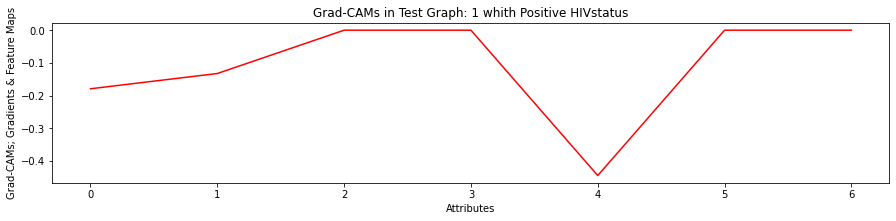

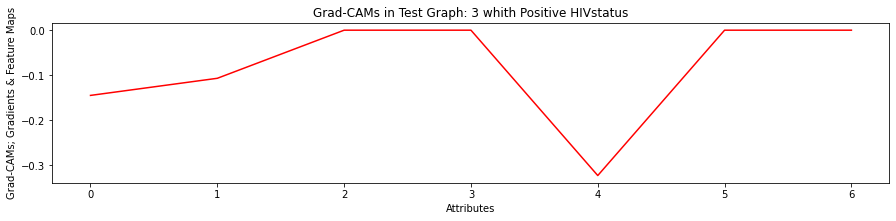

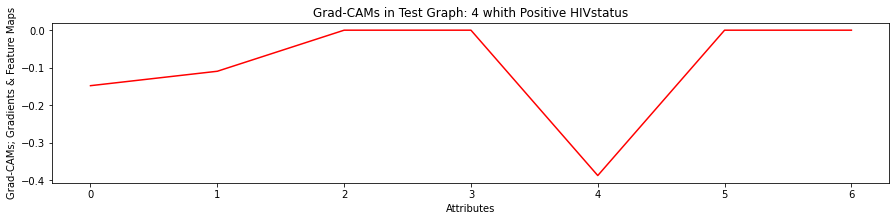

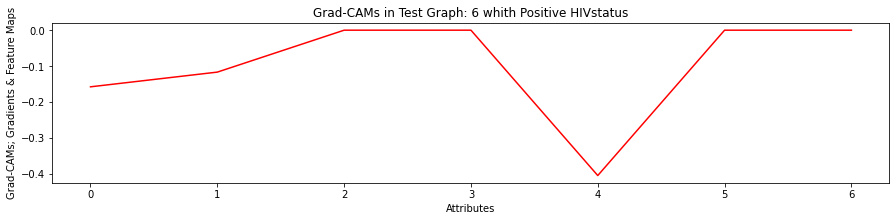

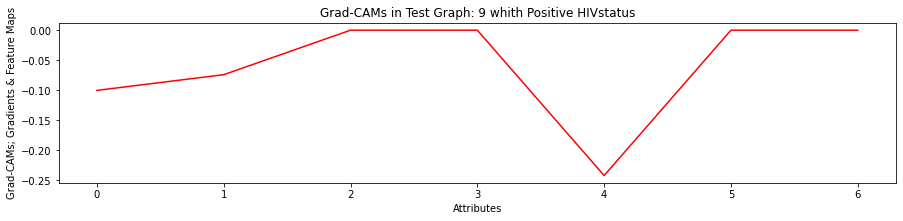

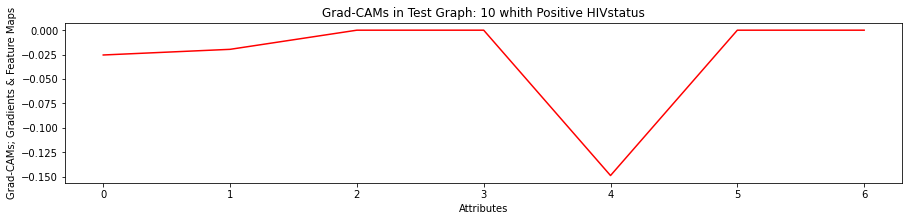

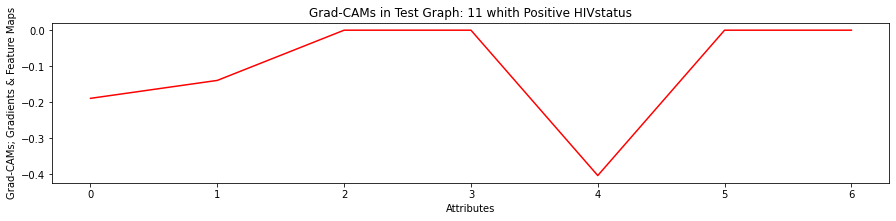

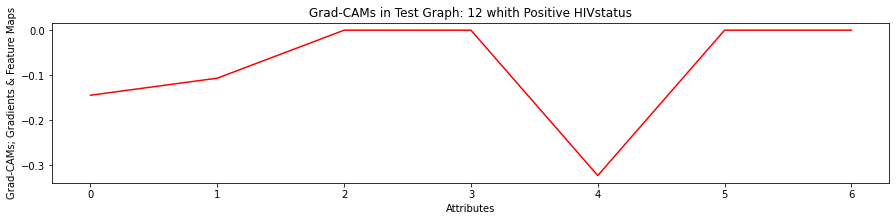

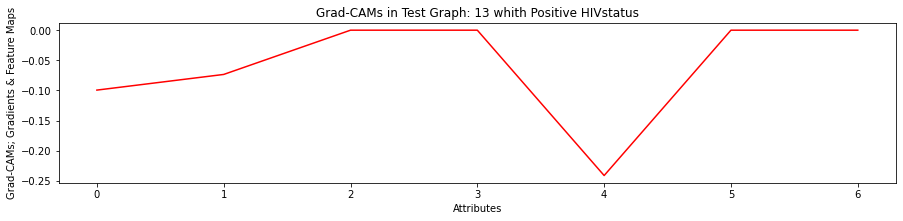

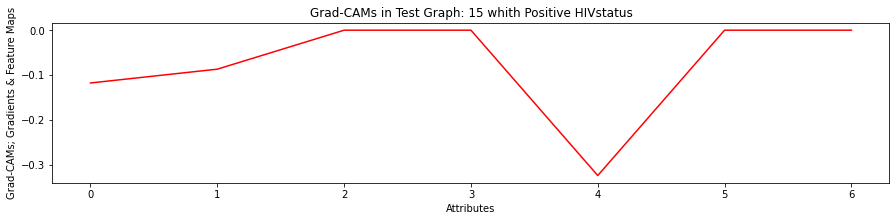

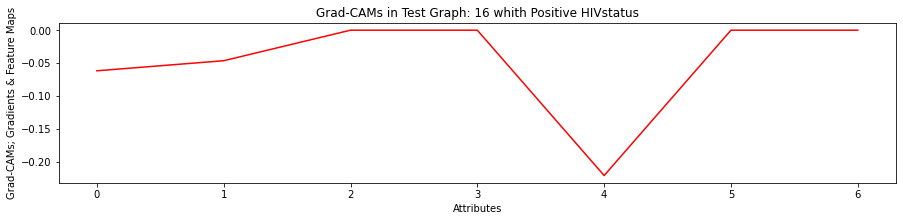

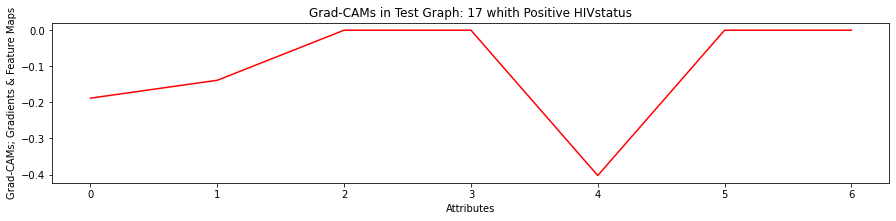

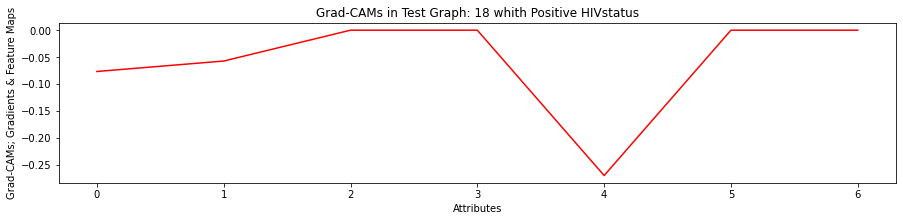

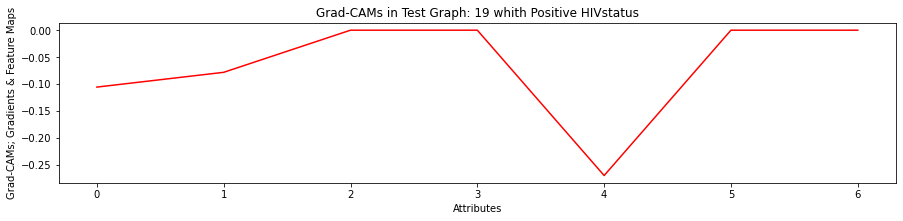

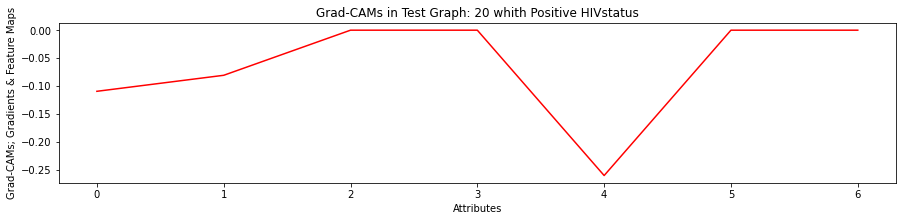

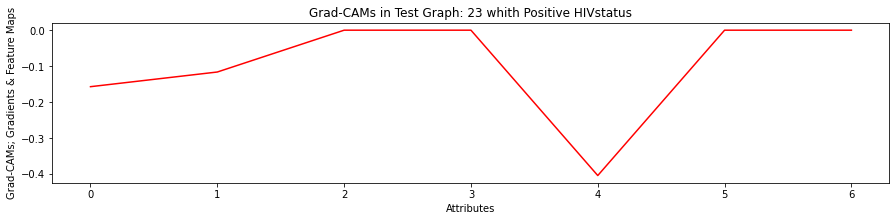

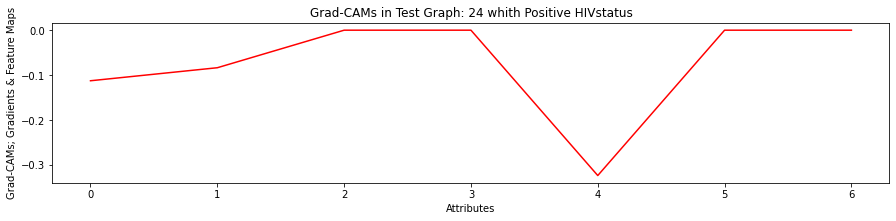

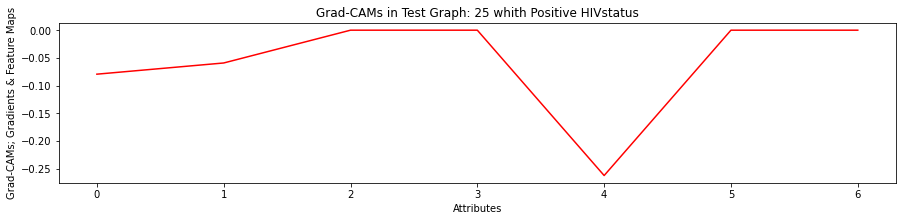

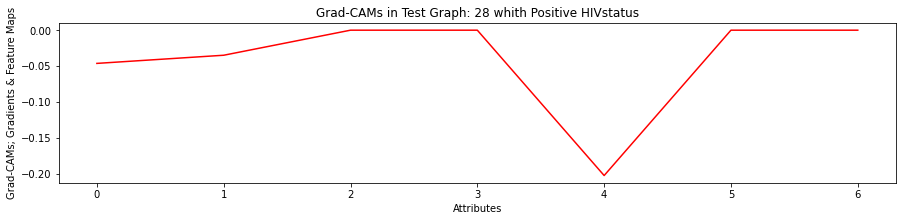

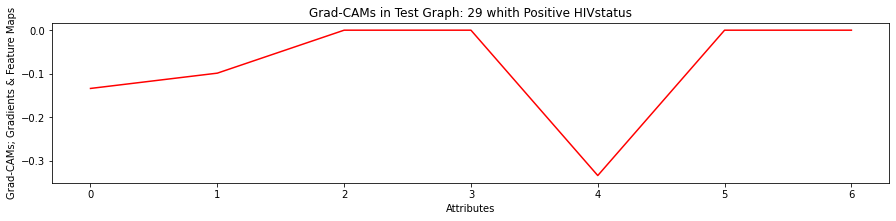

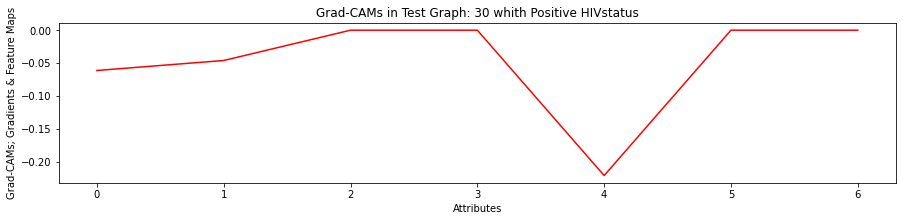

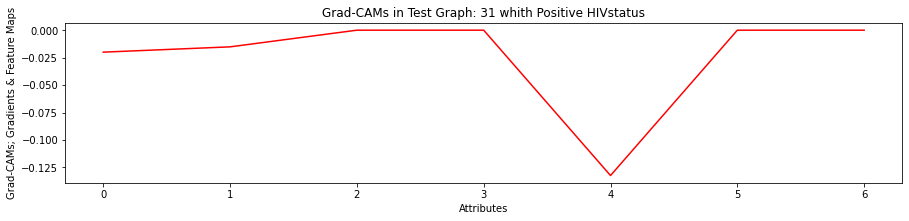

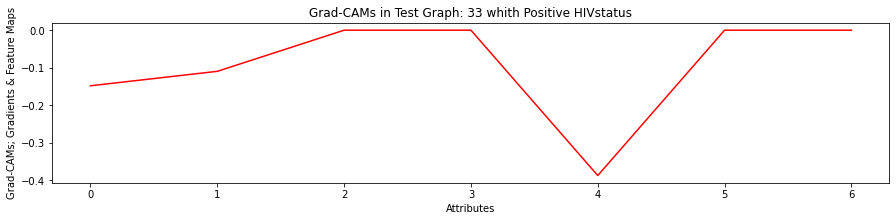

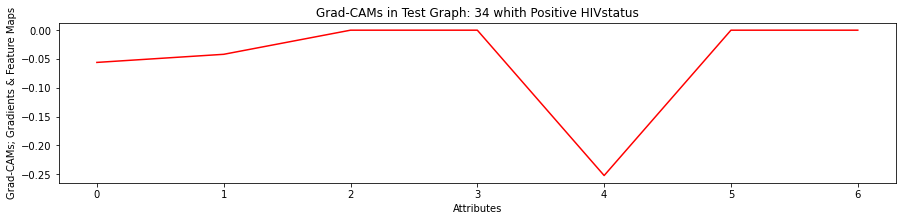

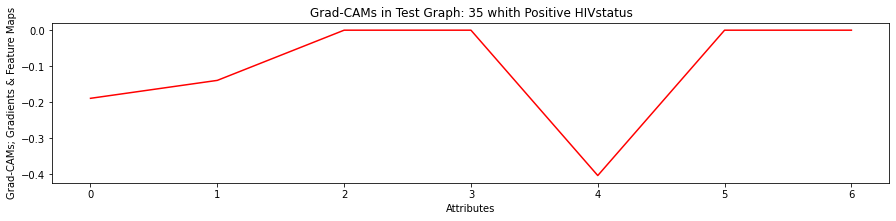

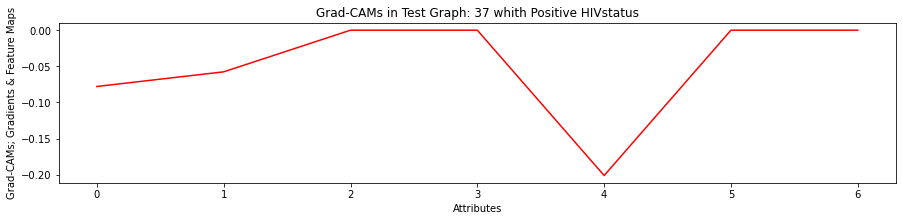

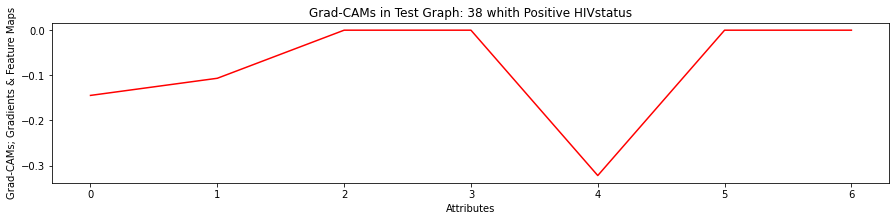

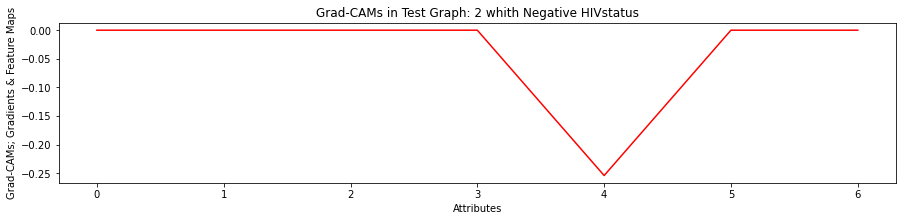

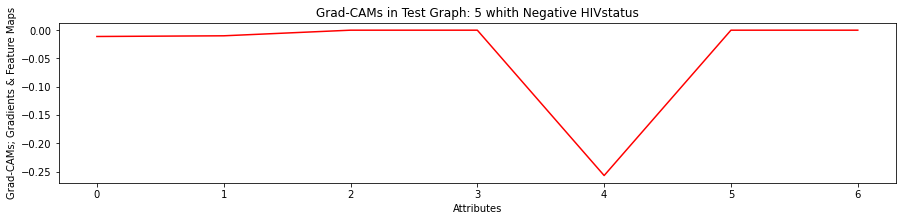

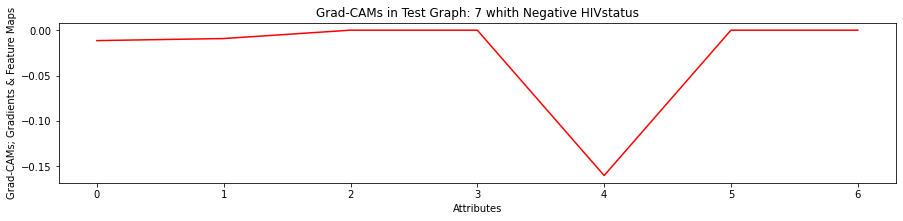

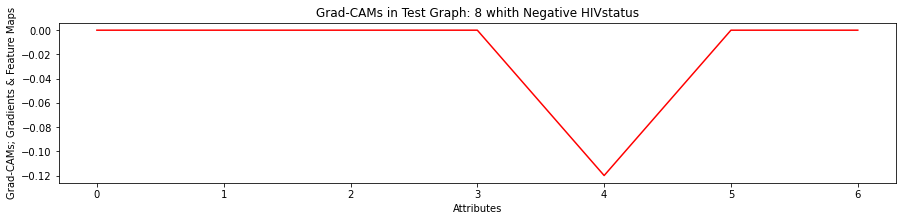

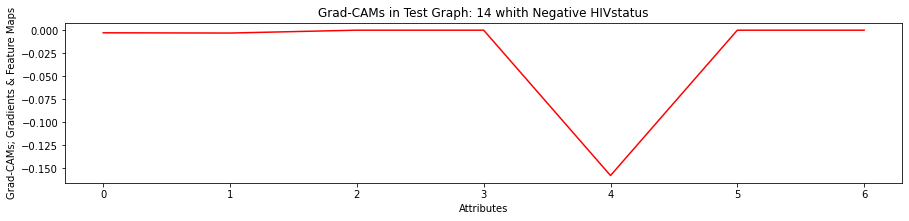

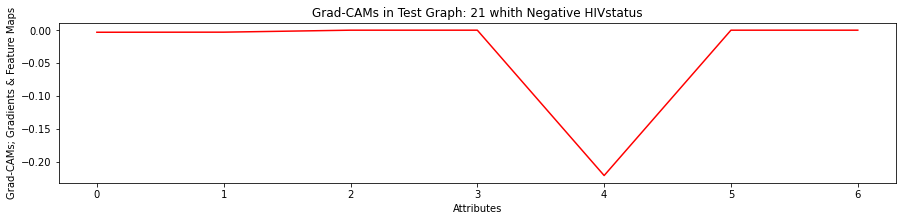

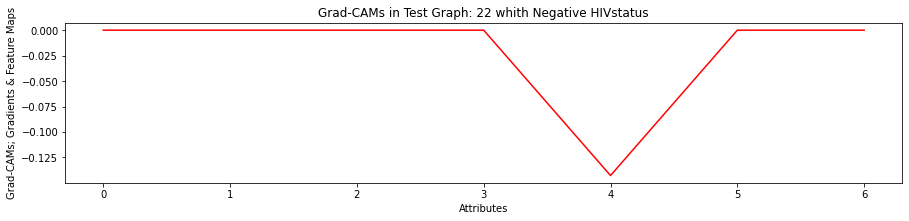

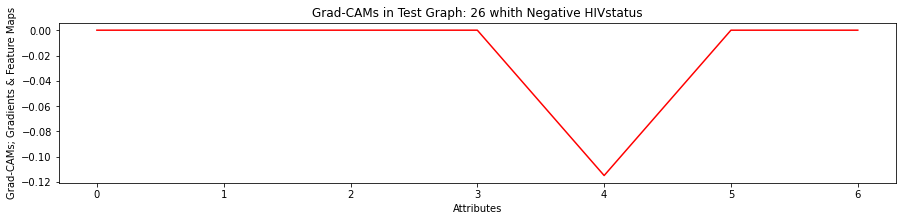

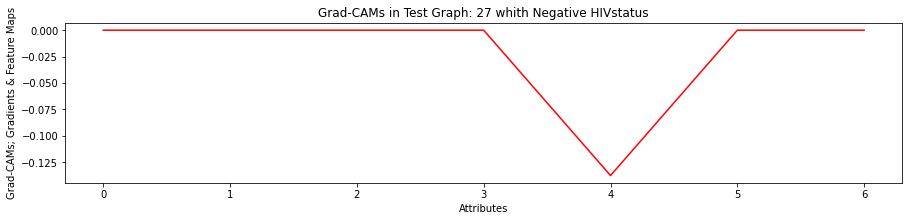

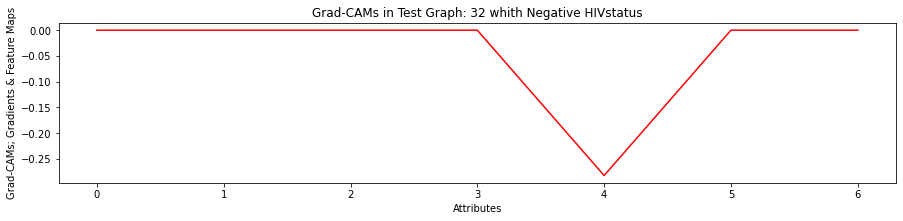

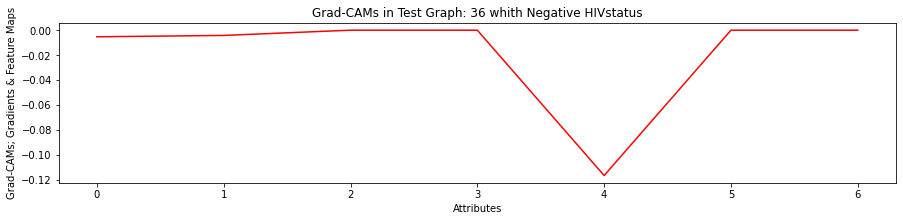

In [ ]:
HIV_status = "Positive HIV"
for i in range(len(HIV_POS)):
  visualize_Grad_CAMs(HIV_POS[i], HIV_POS_index[i], HIV_status)

HIV_status = "Negative HIV"
for i in range(len(HIV_NEG)):
  visualize_Grad_CAMs(HIV_NEG[i], HIV_NEG_index[i], HIV_status)

In [ ]:
#print(Weights_of_the_Winner_Node[0])
#print('***********************************')
#print(Feature_Maps_of_the_Last_Conv[0][0])
#print('===================================')
#print(CAMs_of_Nodes_for_each_graph[0][0])

In [ ]:
#print(np.shape(FeatureMaps_of_the_Last_Conv))
#for i in range(len(FeatureMaps_of_the_Last_Conv[0])):
#  print(FeatureMaps_of_the_Last_Conv[0][i])

In [ ]:
#CAM_model_GCN.eval()
#x = []
#for batched_data in test_dataset:
#    Last_Conv, GAP, cam_preds = CAM_model_GCN(batched_data.x, batched_data.edge_index, batched_data.batch)
#    x.append(Last_Conv)

In [ ]:
#print('CAM_Test_Last_Conv')
#print(CAM_Test_Last_Conv)
#print("=========================================================================")
#print(len(x))

#summ = 0
#for i in range(len(x)):
#  print(len(x[i]), test_dataset[i].num_nodes)
#  summ=summ+len(x[i])
#print(summ)

# **Upto the last Conv layer**

# **Gradients of CAM**


In [ ]:
'''def accumulate_gradients(model_for_you):
  before_CAM = []
  after_CAM = []

  for name, param in model_for_you.named_parameters():

    if name == "conv1.bias":
      before_CAM.append(param.grad.detach().clone())
      param.grad = torch.square(param.grad)
      after_CAM.append(param.grad.detach().clone())
    if name == "conv1.lin.weight":
      before_CAM.append(param.grad.detach().clone())
      param.grad = torch.square(param.grad)
      after_CAM.append(param.grad.detach().clone())

    if name == "conv2.bias":
      before_CAM.append(param.grad.detach().clone())
      param.grad = torch.square(param.grad)
      after_CAM.append(param.grad.detach().clone())
    if name == "conv2.lin.weight":
      before_CAM.append(param.grad.detach().clone())
      param.grad = torch.square(param.grad)
      after_CAM.append(param.grad.detach().clone())

    if name == "conv3.bias":
      before_CAM.append(param.grad.detach().clone())
      param.grad = torch.square(param.grad)
      after_CAM.append(param.grad.detach().clone())
    if name == "conv3.lin.weight":
      before_CAM.append(param.grad.detach().clone())
      param.grad = torch.square(param.grad)
      after_CAM.append(param.grad.detach().clone())

    if name == "lin.bias":
      before_CAM.append(param.grad.detach().clone())
      param.grad = torch.square(param.grad)
      after_CAM.append(param.grad.detach().clone())
    if name == "lin.weight":
      before_CAM.append(param.grad.detach().clone())
      param.grad = torch.square(param.grad)
      after_CAM.append(param.grad.detach().clone())


  return before_CAM, after_CAM'''

In [ ]:
#holder_of_old_gradients, holder_of_new_gradients = accumulate_gradients(CAM_model_GCN)

In [ ]:
#print(len(holder_of_new_gradients))

8
